In [ ]:
# SETUP

In [53]:
from models import Market, Transactions, PIB, models_connection, models_keyspace
from cassandra.cqlengine import connection,management
from cassandra.cluster import Cluster

import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import traceback

"""
Scylla Manager
This class does the setup to use scylla. You must give the models that you want to be sync.
"""
class ScyllaManager():
    # Host to connect
    host_list = ['datadb']
    def __init__(self, models) -> None:
        # Do connection
        self.session = Cluster(self.host_list).connect()

        # Register connection
        self.register_session(models_connection)

        # It creates the specified keyspace, it can be anything, but my models export their respective keyspace and connection name
        self.create_keyspace(models_keyspace,[models_connection])
        
        #Sync models
        for Model in models:
            management.sync_table(Model)

    # Specifications for the context logic
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, tb):
        connection.unregister_connection(models_connection)
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        return True

    def close(self):
        connection.unregister_connection(models_connection)

    # Handler for registering the connection
    def register_session(self, connection_name):
        connection.register_connection(connection_name, session=self.session)
    
    # Handler for creating keyspace. It always create a SimpleStrategy keyspace with one node. Change it at will and your own risk.
    def create_keyspace(self, name, connections):
        management.create_keyspace_simple(name,1,True,connections)

In [ ]:
# Create scylla_manager() (There will be a warning I don't really know how to get rid of it but it doesn't affect the script)

In [2]:
scylla_manager = ScyllaManager(models=[Market, Transactions, PIB])

/home/sergiopereo/ITAM/NoSQL/gmw/data_processor/dataenv/lib/python3.10/site-packages/cassandra/cqlengine/management.py:553: UserWarning: CQLENG_ALLOW_SCHEMA_MANAGEMENT environment variable is not set. Future versions of this package will require this variable to enable management functions.
  warnings.warn(msg)


In [8]:
# How to get the PIB of a day?
# select * from pib where year=<year> and month=<month> and day=<day>;

In [17]:
day=datetime.datetime(2023, 10, 28, 0, 0, 0, 0)
pib_day=PIB.objects(year=day.year, month=day.month, day=day.day)
print(f"PIB from day {day}: {pib_day[0].value}")

PIB from day 2023-10-28 00:00:00: 266051386059266563


In [ ]:
# How is the PIB doing inside the economy?
# select * from pib;

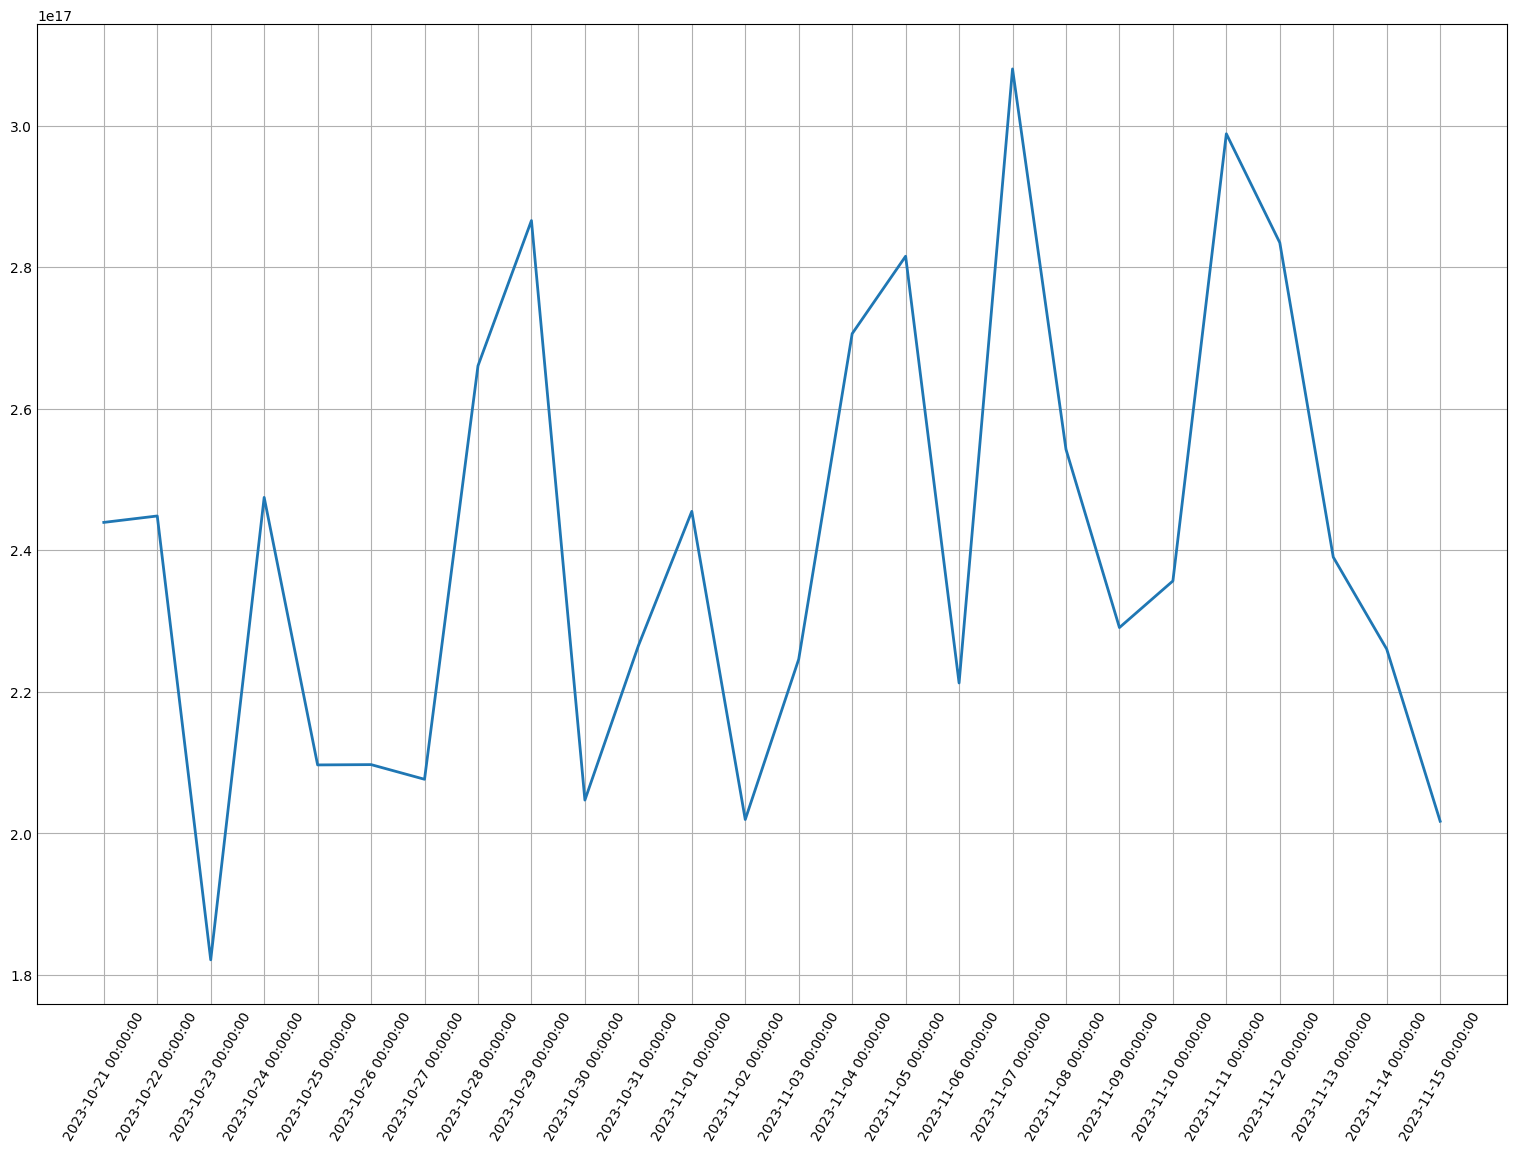

In [3]:
plt.style.use('_mpl-gallery')
# make data
pib = PIB.objects().all()
x = [str(datetime.datetime(p.year, p.month, p.day, 0, 0, 0, 0)) for p in pib]
y = [p.value for p in pib]
# plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(x, y, linewidth=2.0)
plt.xticks(rotation=60)
plt.show()
    

In [ ]:
# How many transactions are being made of an specific items list a day?
# select count(*) from transactions where item_id in (24295, 24358, 24351, 24357, 24289, 24300, 24283, 24277, 24294, 24341, 24350, 24356, 24288, 24299, 24282, 19721);

In [25]:
subset_items = [24295, 24358, 24351, 24357, 24289, 24300, 24283, 24277, 24294, 24341, 24350, 24356, 24288, 24299, 24282, 19721]
transactions = Transactions.objects.filter(item_id__in=subset_items).limit(None)
t_count = len(transactions)
print("Transactions", t_count)

Transactions 48117


In [ ]:
# How to divide in buys and sells this transactions?
# This can't be done without restricting the date because of the Scylla table format, so the only thing we can do is filtering ourselves this information

In [26]:
transactions_sells = [t for t in transactions if t.trans_type=="sells"]
ts_count = len(transactions_sells)
print("Sells transactions", ts_count)
print("Buys transactions", t_count-ts_count)

Sells transactions 22109
Buys transactions 26008


In [ ]:
# How can I compare the demand of these items with respect of the entire demand of objects?
# select sum(price),sum(quantity) from gmw_dw.transactions where item_id in <items list> and date>=<initial data> and date<<final date>

In [6]:
pib = PIB.objects().all()
transactions_lookup = scylla_manager.session.prepare("select sum(price),sum(quantity) from gmw_dw.transactions where item_id in ? and date>=? and date<?")
percentages = []
for p in pib:
    initial=datetime.datetime(p.year, p.month, p.day, 0, 0, 0, 0)
    query_set = scylla_manager.session.execute(transactions_lookup, [subset_items, initial, initial+datetime.timedelta(1)])
    percentage_of_total = (query_set.one()['system.sum(price)']*query_set.one()['system.sum(quantity)'])/p.value
    percentages.append(percentage_of_total)
print('The percentage of the "demand" of this items is: ', statistics.mean(percentages))

The percentage of the "demand" of this items is:  2.3690375474307067e-05


In [ ]:
# How is it doing the Consumer Price Index of that set of items

In [67]:
pib = PIB.objects().all()
transactions_lookup = scylla_manager.session.prepare("select price,trans_type from gmw_dw.transactions where item_id=? and date>=? and date<?")
sells_prices = {"date": []}
buys_prices = {"date": []}
for i in subset_items:
    sells_prices[i] = []
    buys_prices[i] = []
for p in pib:
    initial=datetime.datetime(p.year, p.month, p.day, 0, 0, 0, 0)
    for i in subset_items:
        query_set = scylla_manager.session.execute(transactions_lookup, [i, initial, initial+datetime.timedelta(1)])
        is_sells_set = False
        is_buys_set = False
        for t in query_set:
            if not is_sells_set or not is_buys_set:
                if not is_sells_set and t["trans_type"]=="sells":
                    sells_prices[i].append(t["price"])
                    is_sells_set = True
                elif not is_buys_set and t["trans_type"]=="buys":
                    buys_prices[i].append(t["price"])
                    is_buys_set = True
    sells_prices["date"].append(initial)
    buys_prices["date"].append(initial)
#print(sells_prices)
#print(buys_prices)
sells_df = pd.DataFrame(sells_prices)
buys_df = pd.DataFrame(buys_prices)
sells_df['Prices Total']= sells_df.sum(axis=1, numeric_only=True)
cpi_sells_df = sells_df[['date', 'Prices Total']]
buys_df['Prices Total']= buys_df.sum(axis=1, numeric_only=True)
cpi_buys_df = buys_df[['date', 'Prices Total']]
cpi_sells_base = cpi_sells_df['Prices Total'].loc[0]
cpi_buys_base = cpi_buys_df['Prices Total'].loc[0]
cpi_sells_df['CPI'] = (cpi_sells_df['Prices Total']/sells_base)*100
cpi_buys_df['CPI'] = (cpi_buys_df['Prices Total']/cpi_buys_base)*100
print("CPI Sells")
print(cpi_sells_df)
print("CPI Buys")
print(cpi_buys_df)

CPI Sells
         date  Prices Total         CPI
0  2023-10-21         20471  100.000000
1  2023-10-22         20487  100.078159
2  2023-10-23         20634  100.796248
3  2023-10-24         20813  101.670656
4  2023-10-25         20777  101.494798
5  2023-10-26         20370   99.506619
6  2023-10-27         20716  101.196815
7  2023-10-28         20679  101.016072
8  2023-10-29         21537  105.207367
9  2023-10-30         20859  101.895364
10 2023-10-31         21295  104.025206
11 2023-11-01         21819  106.584925
12 2023-11-02         22019  107.561917
13 2023-11-03         22071  107.815935
14 2023-11-04         22084  107.879439
15 2023-11-05         22603  110.414733
16 2023-11-06         22980  112.256363
17 2023-11-07         22500  109.911582
18 2023-11-08         25371  123.936300
19 2023-11-09         24964  121.948122
20 2023-11-10         25826  126.158957
21 2023-11-11         25252  123.354990
22 2023-11-12         25476  124.449221
23 2023-11-13         24207  1

/tmp/ipykernel_223370/2634536594.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_sells_df['CPI'] = (cpi_sells_df['Prices Total']/sells_base)*100
/tmp/ipykernel_223370/2634536594.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_buys_df['CPI'] = (cpi_buys_df['Prices Total']/cpi_buys_base)*100


In [ ]:
# How does the demand of this items look

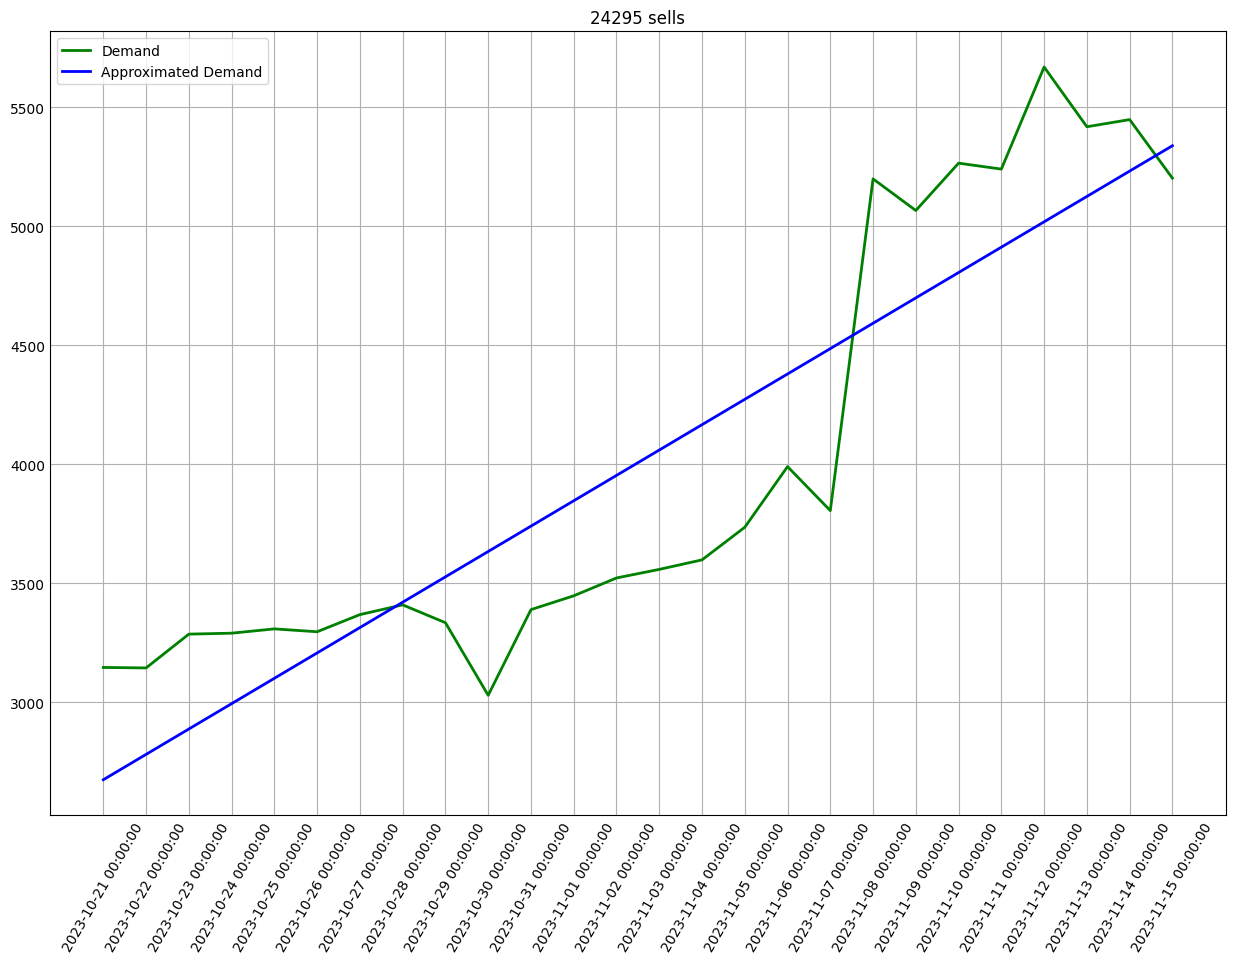

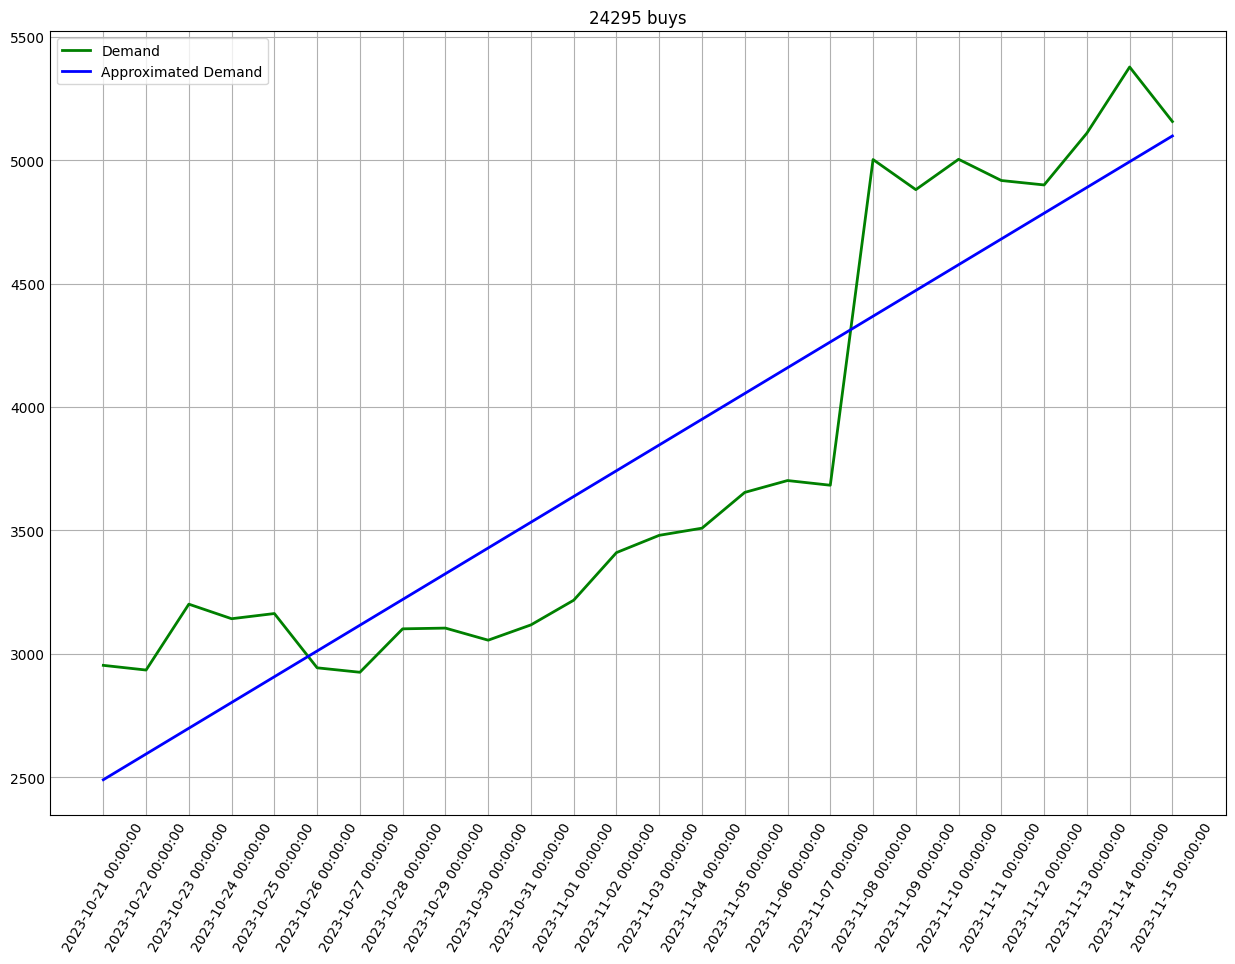

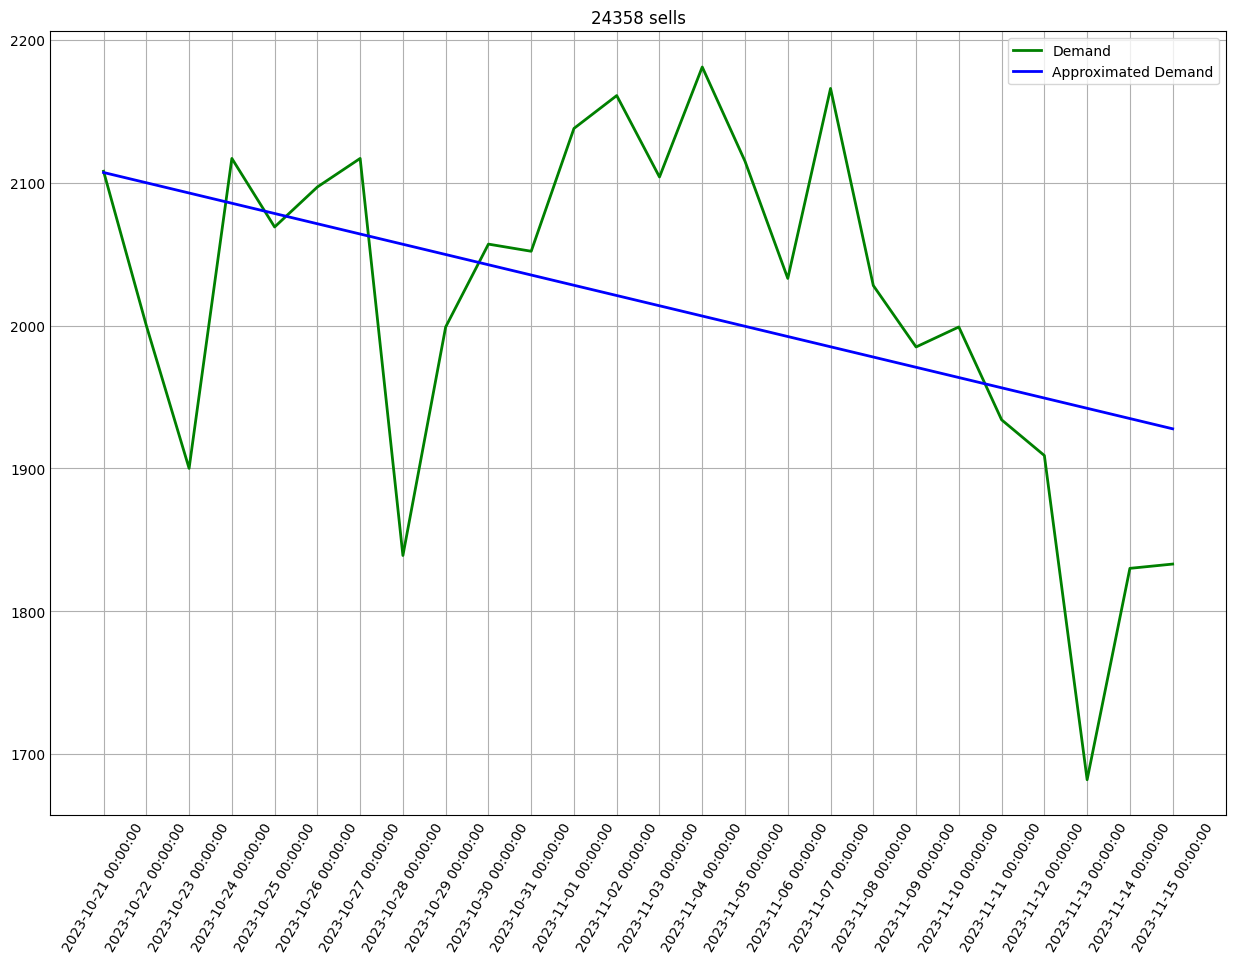

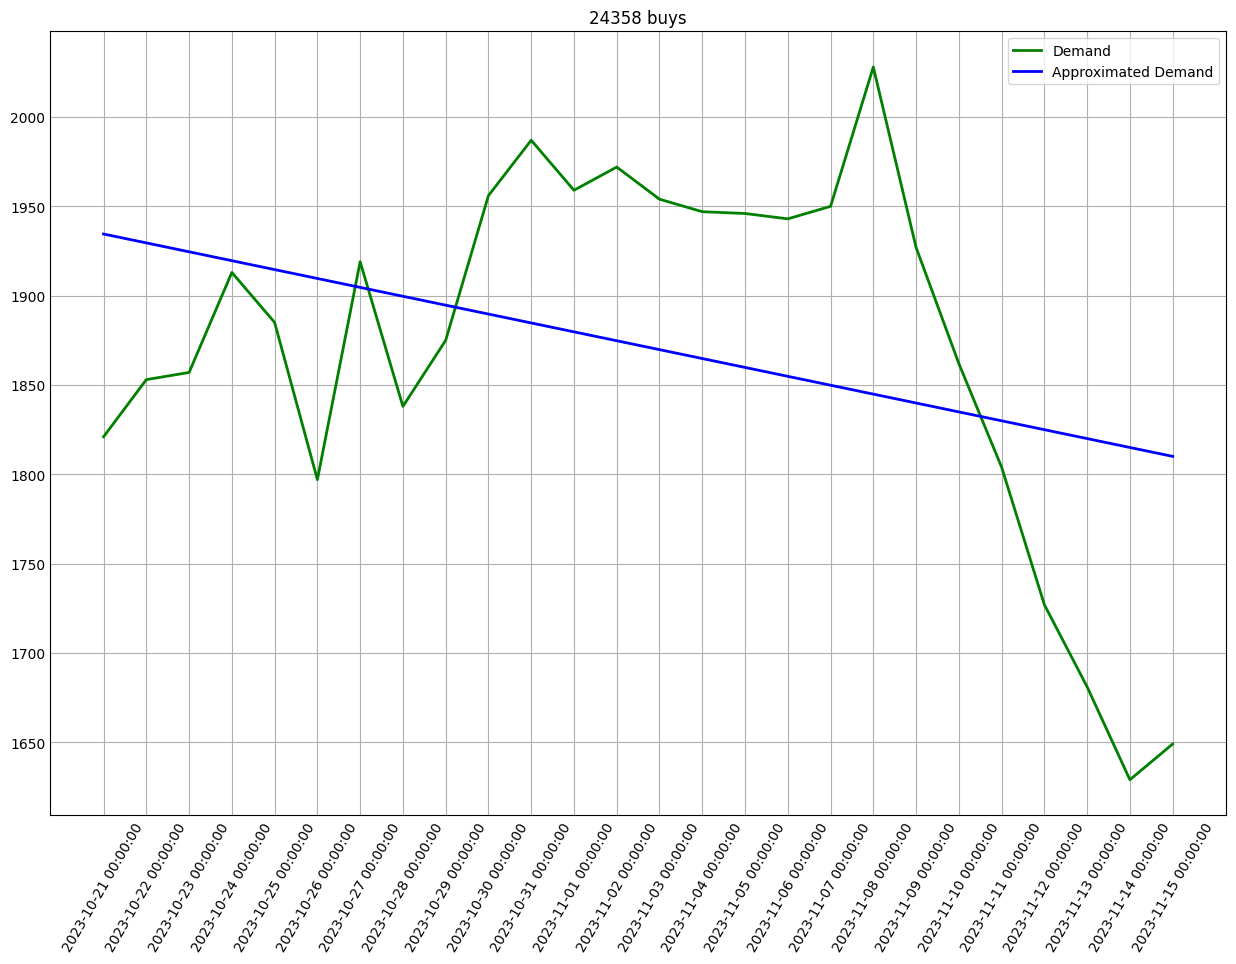

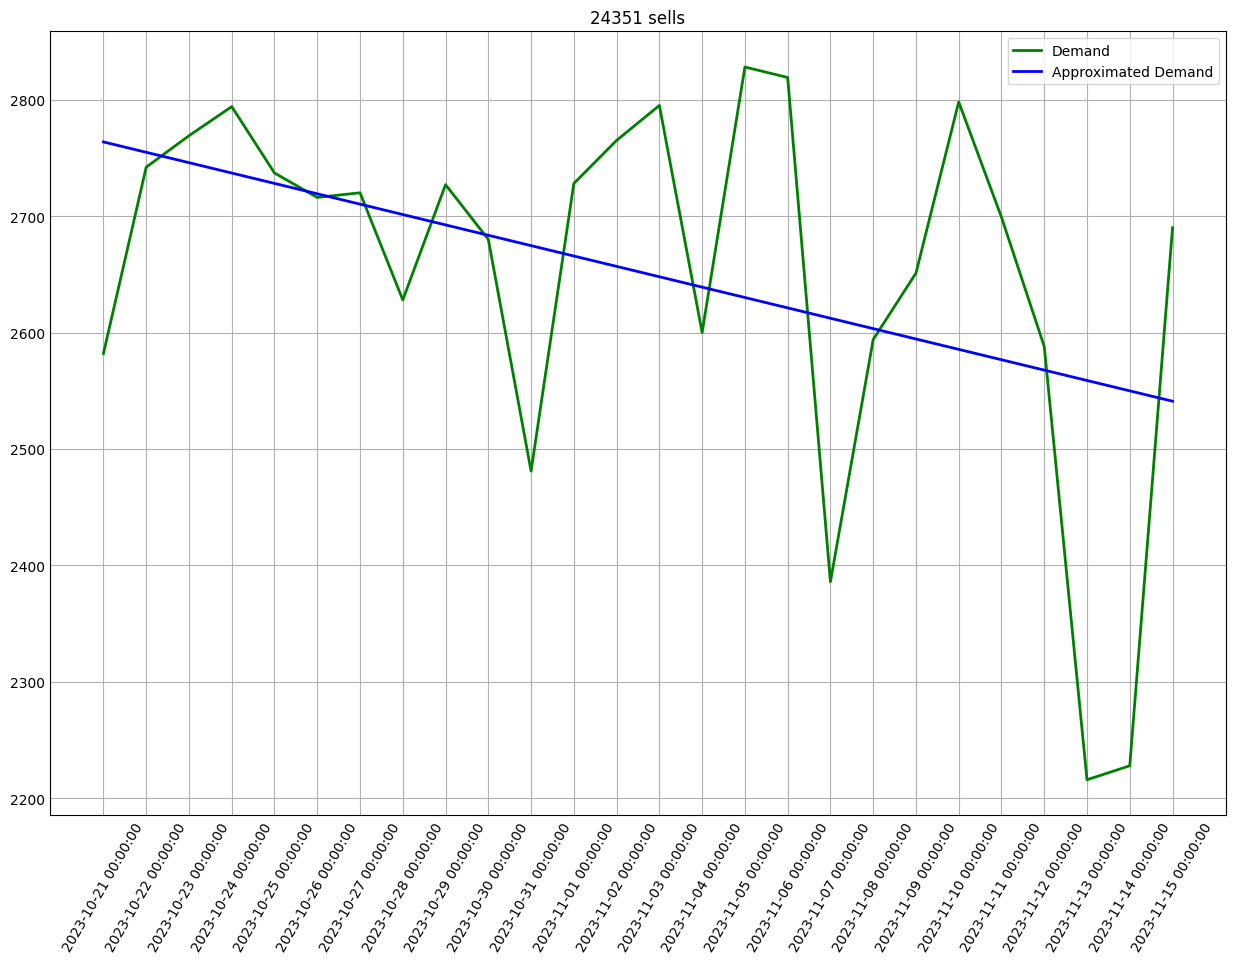

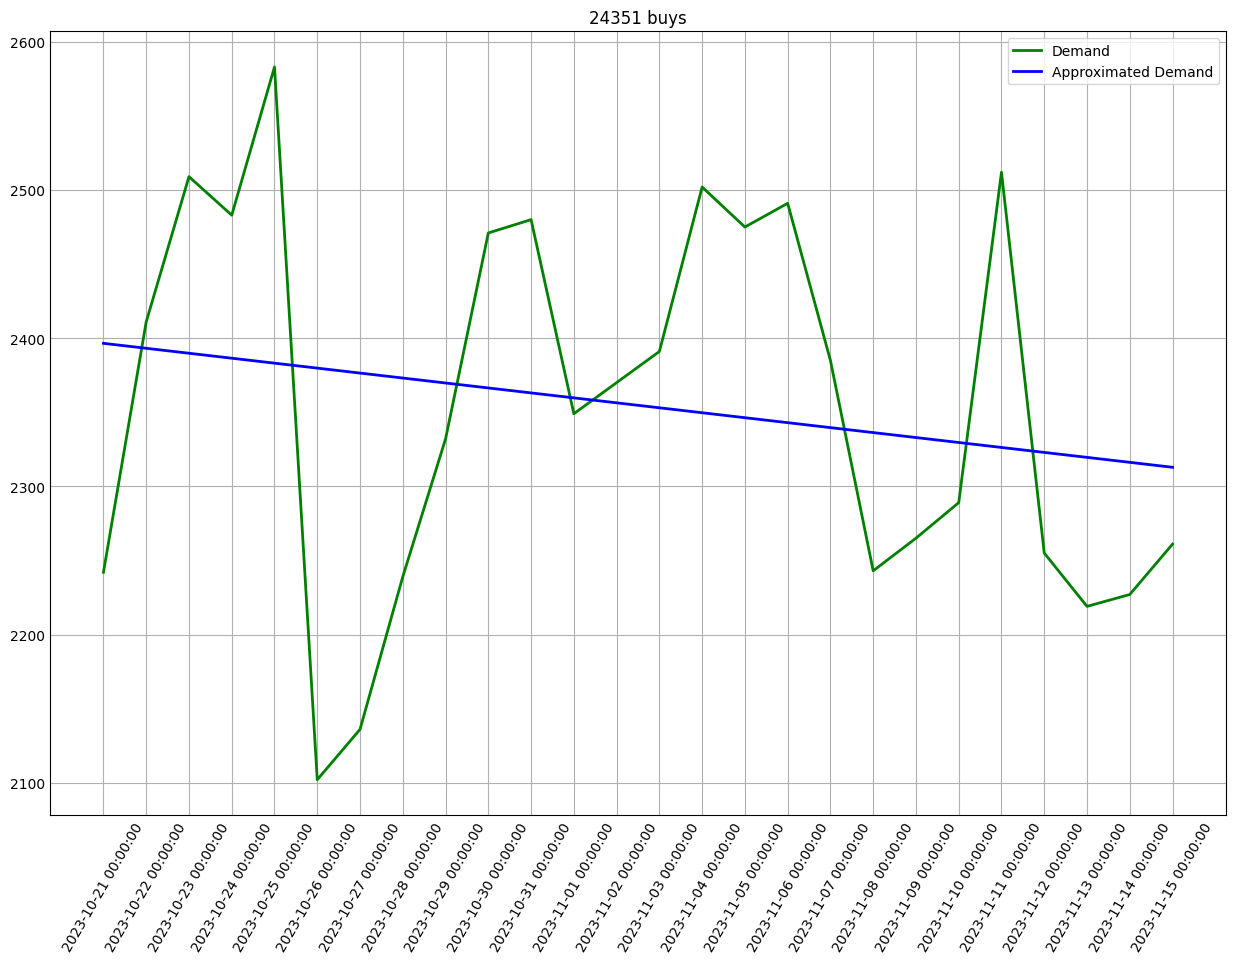

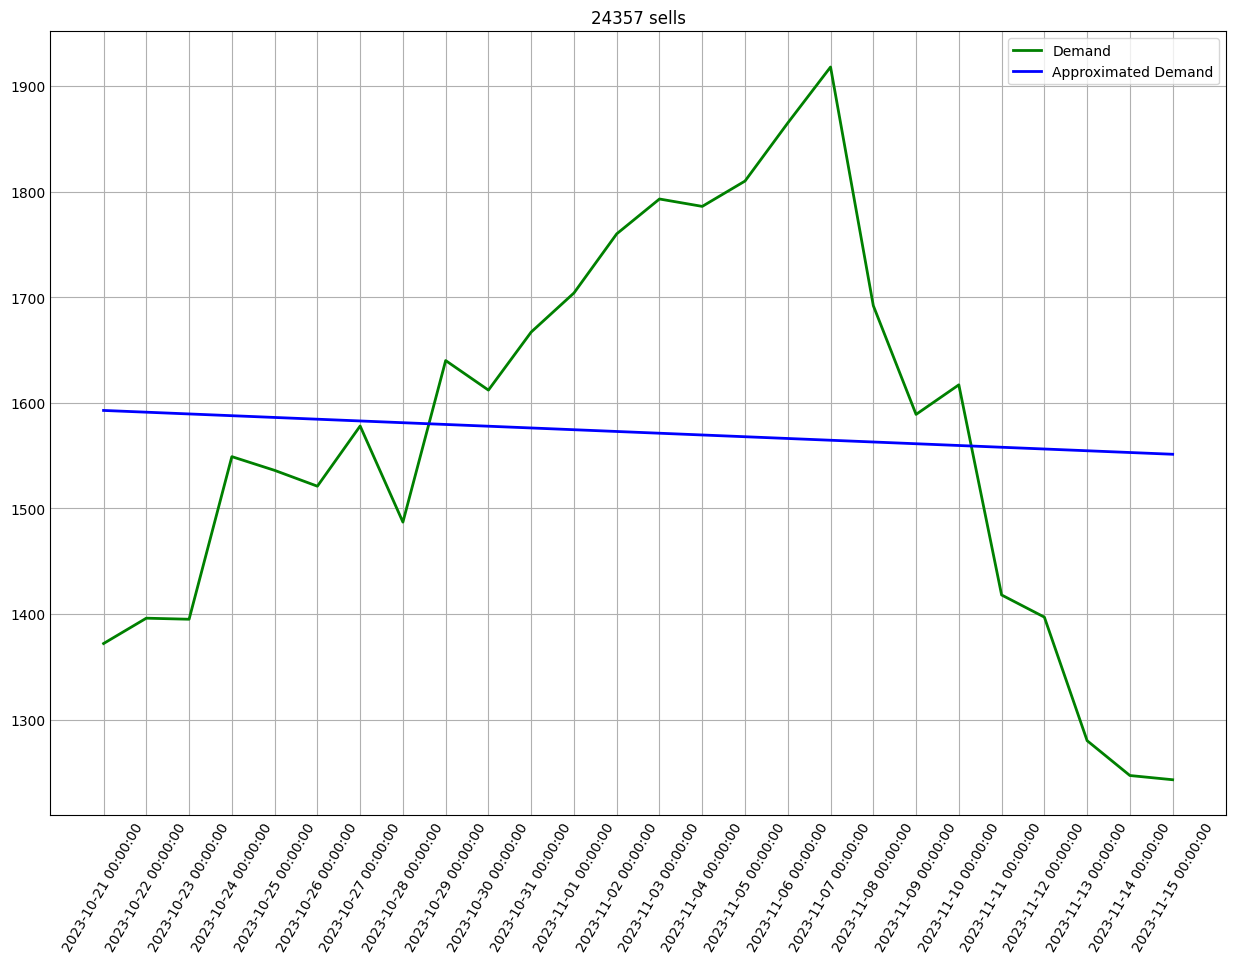

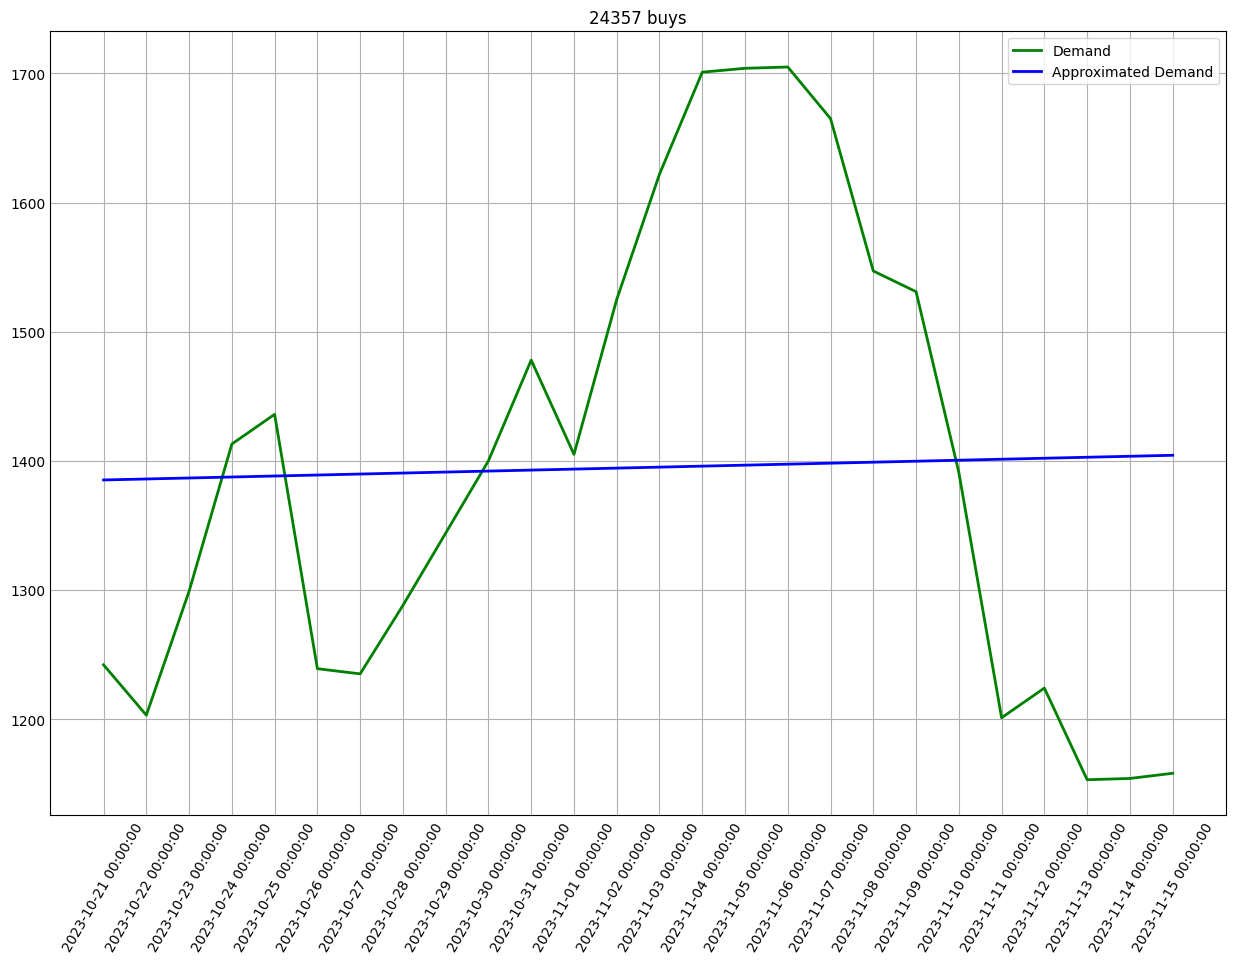

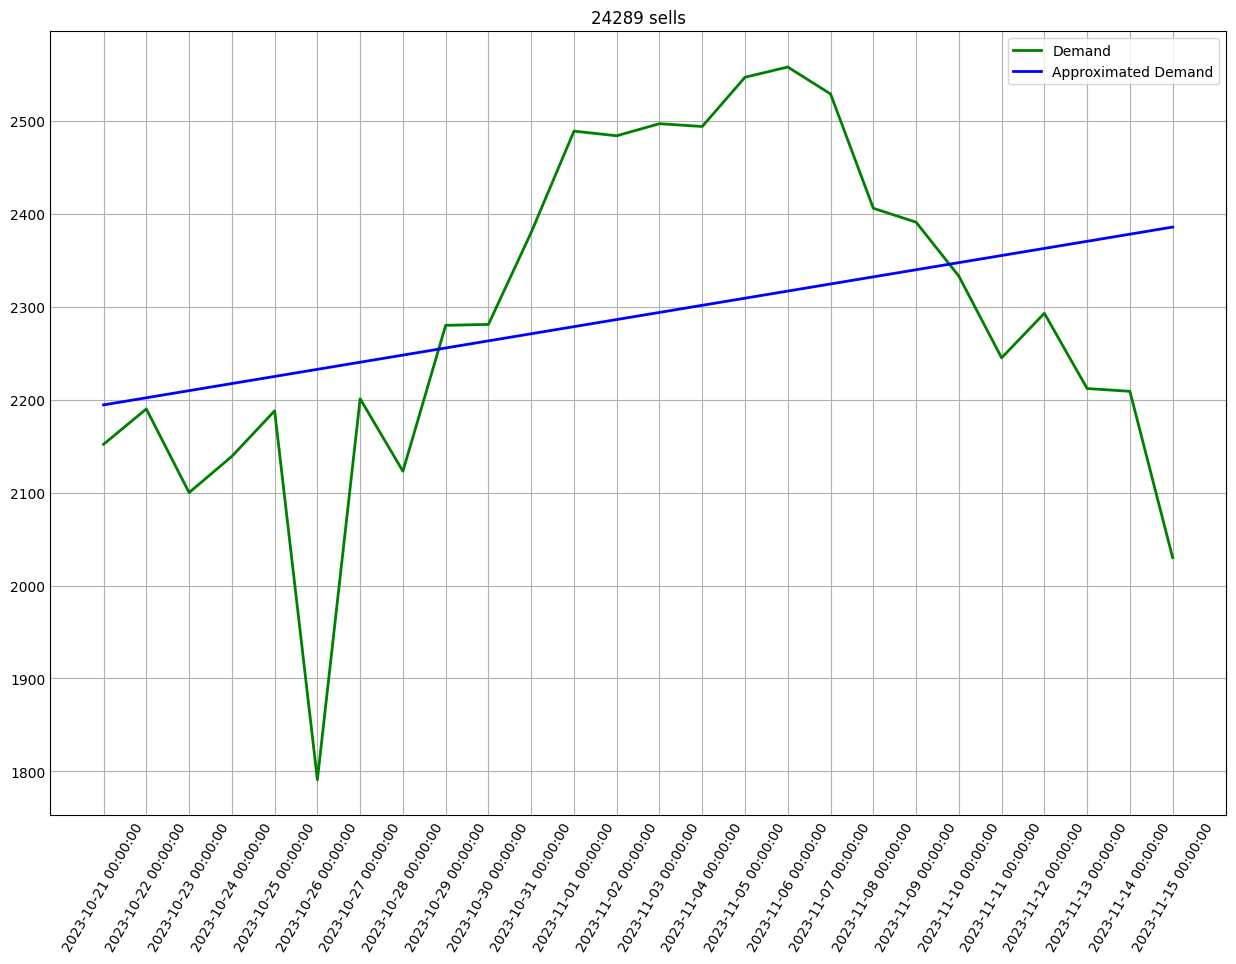

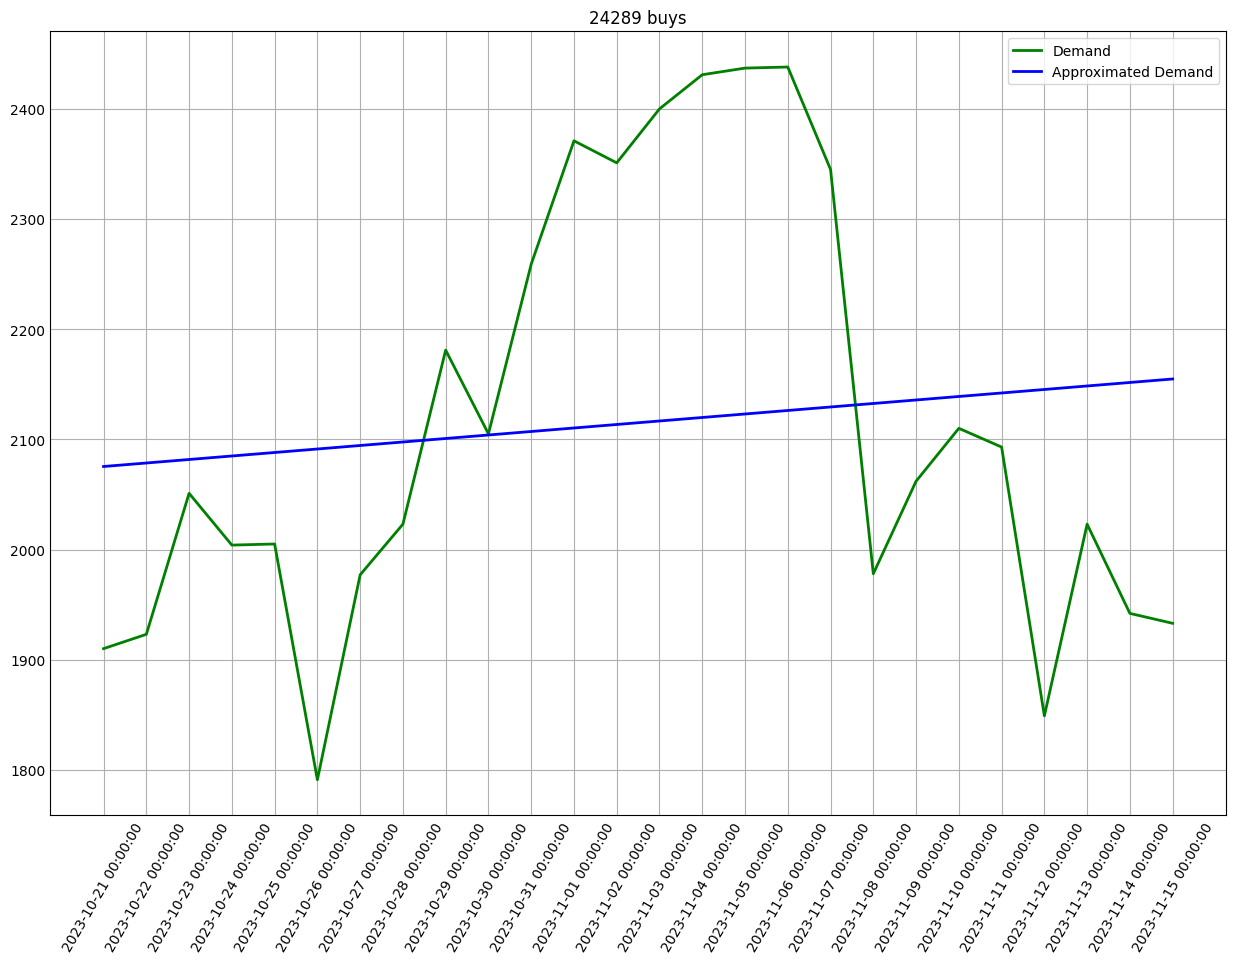

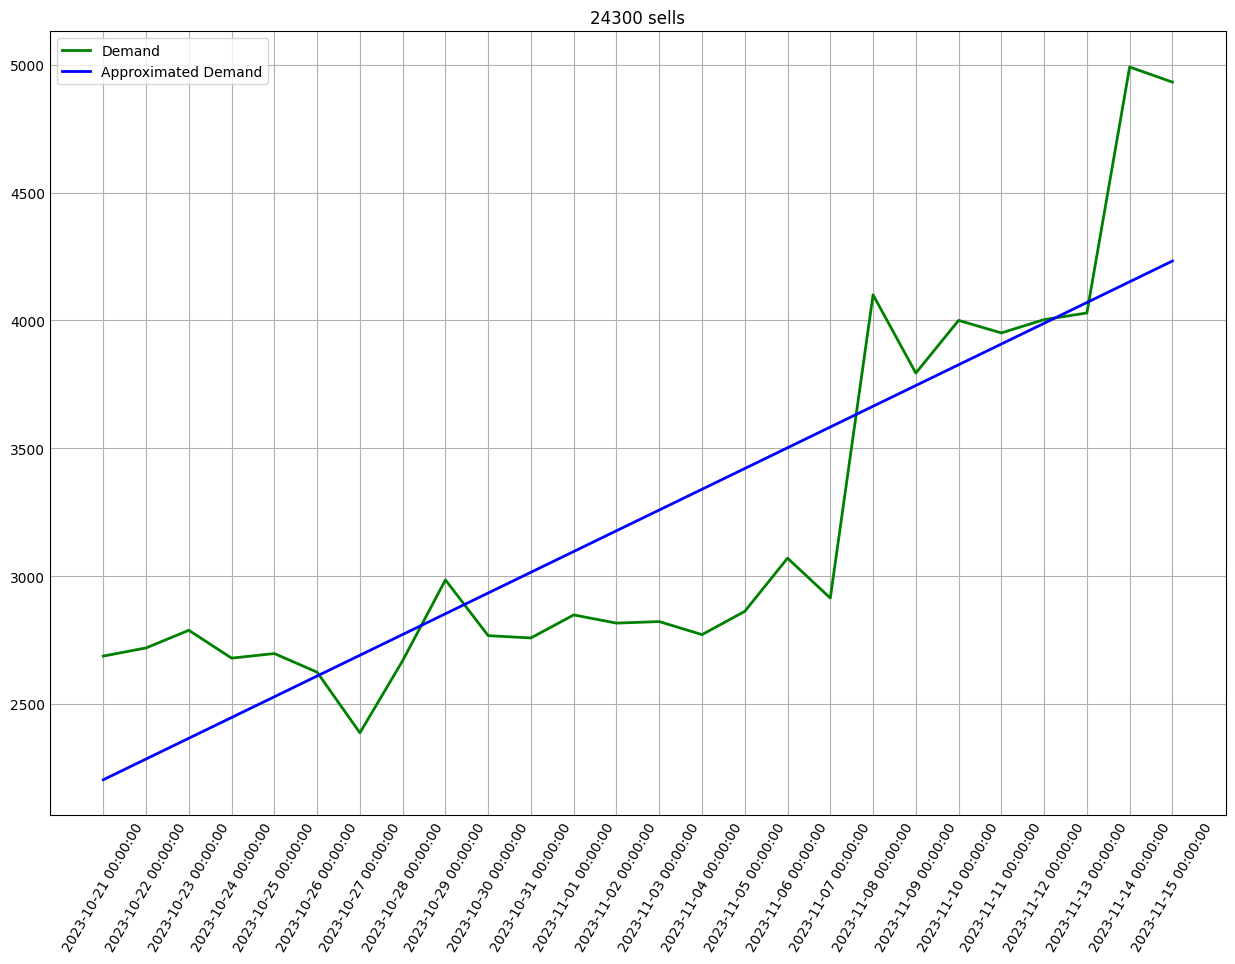

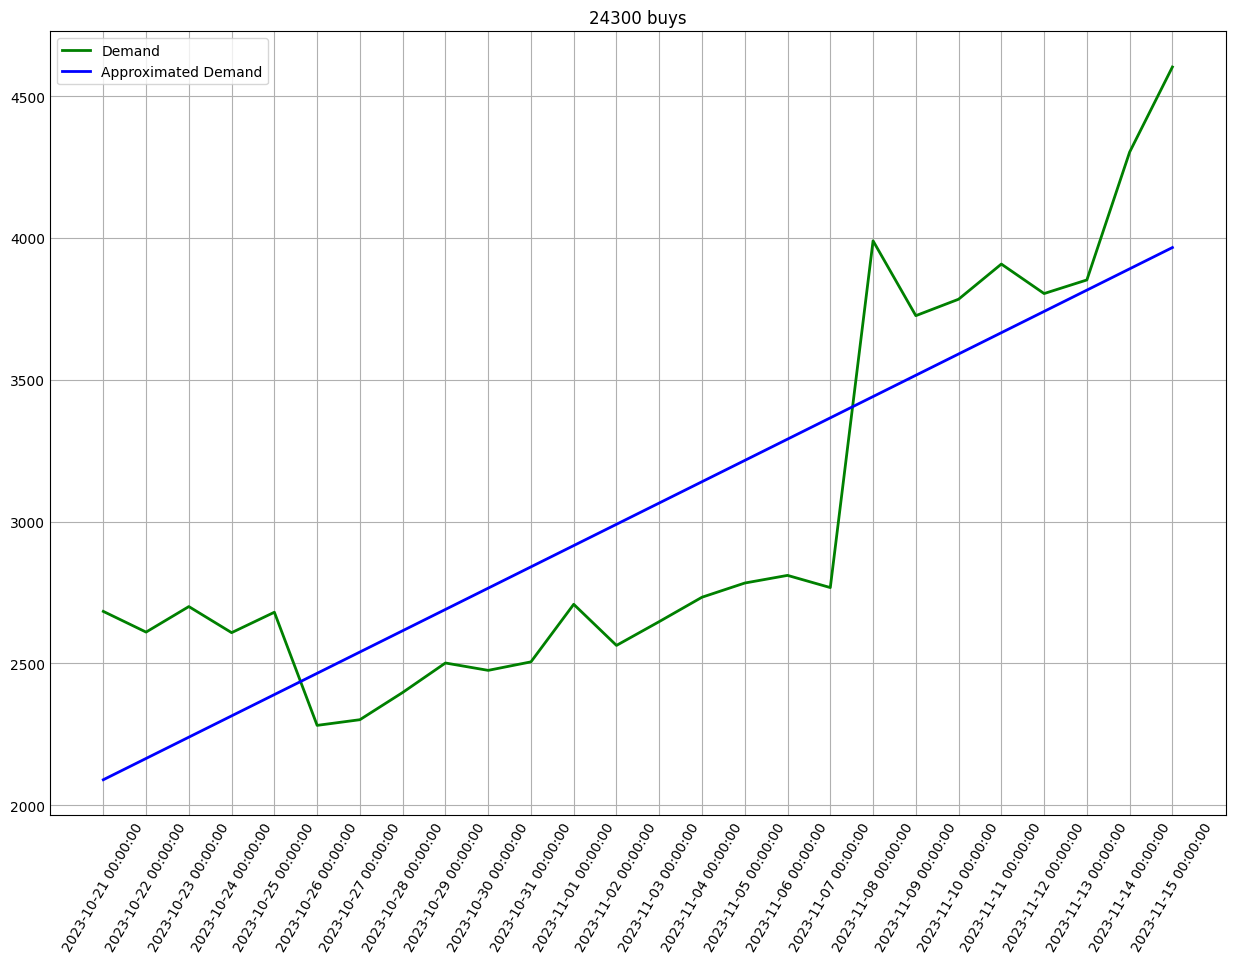

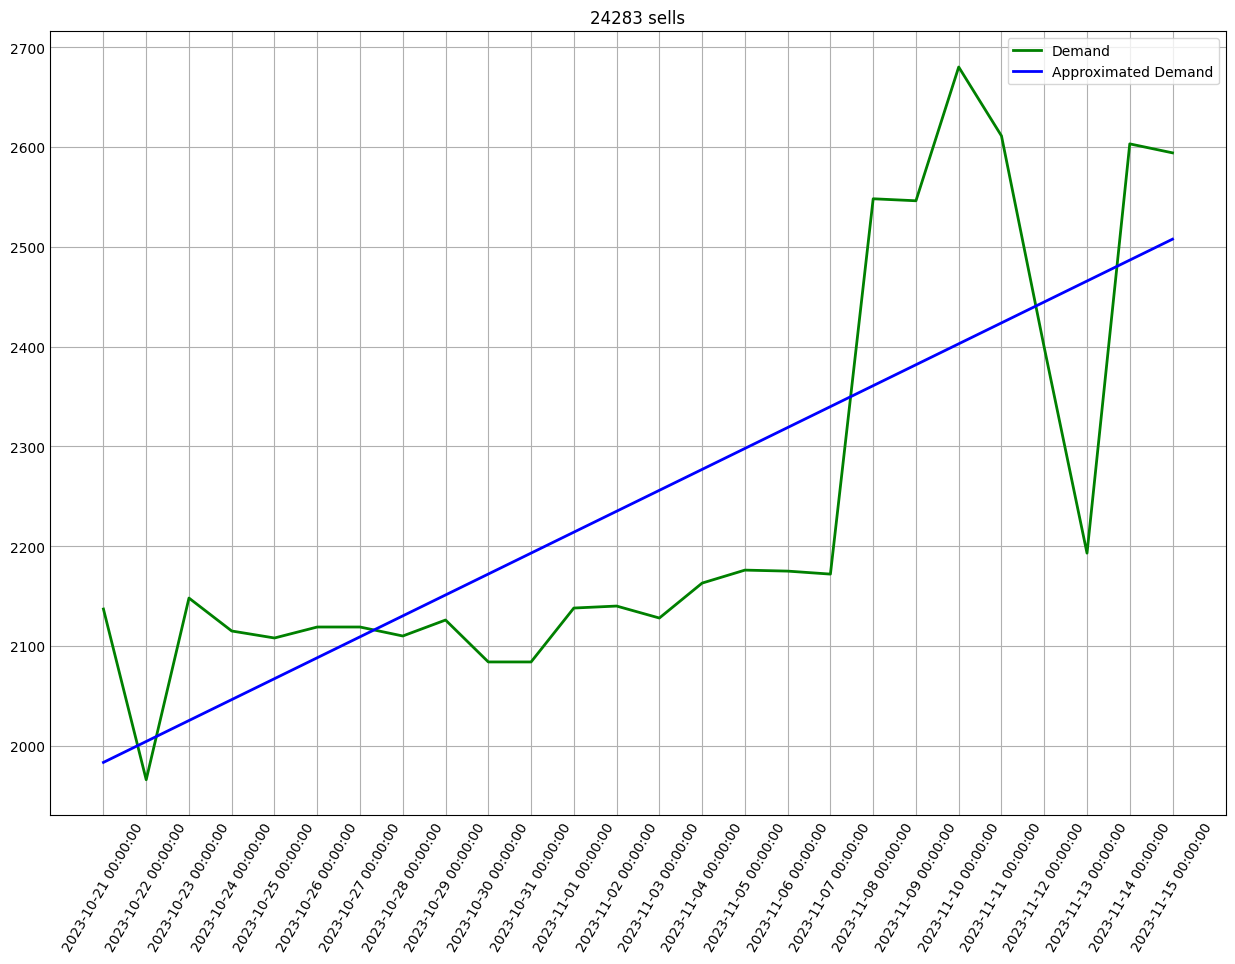

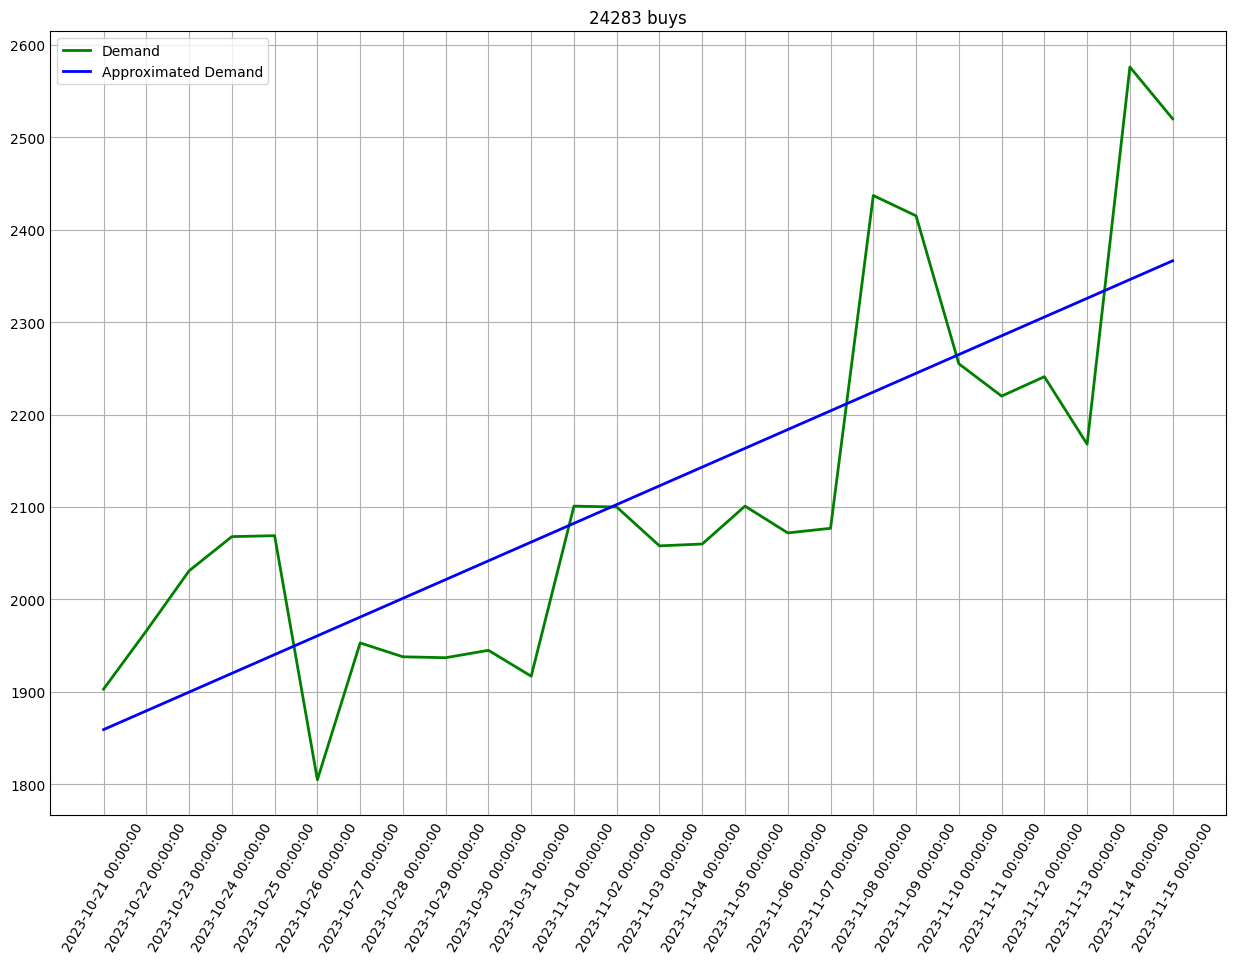

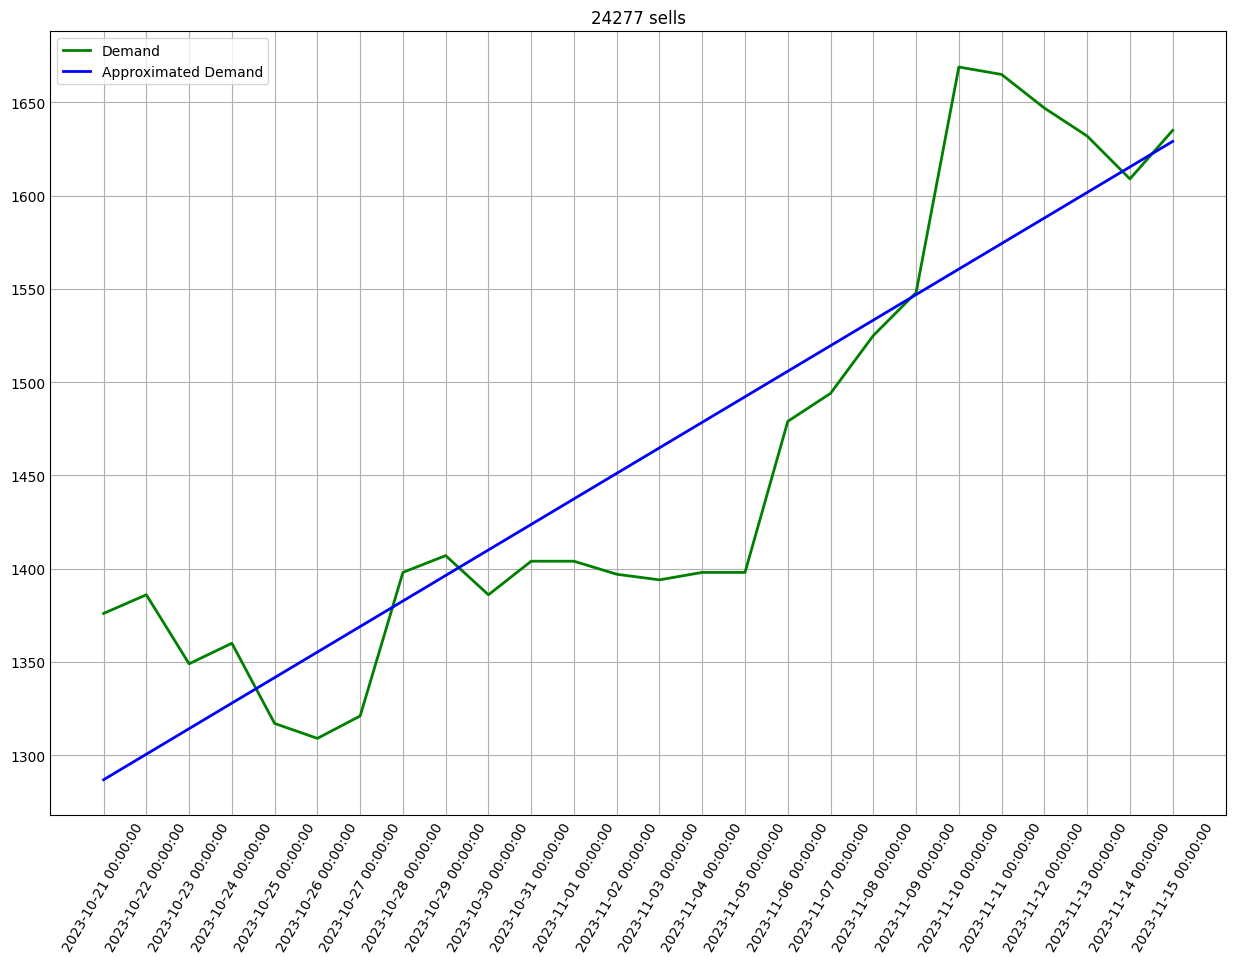

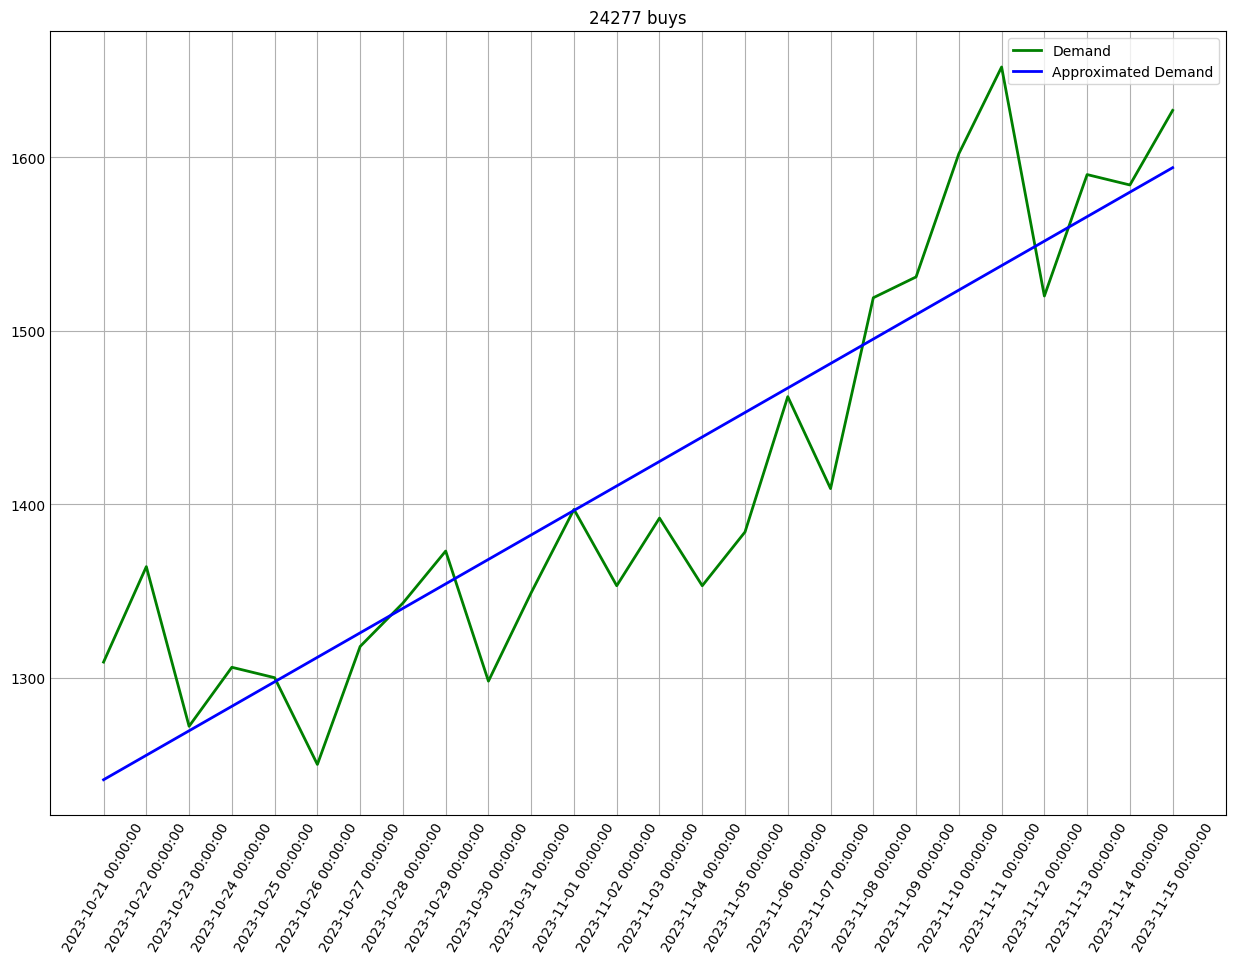

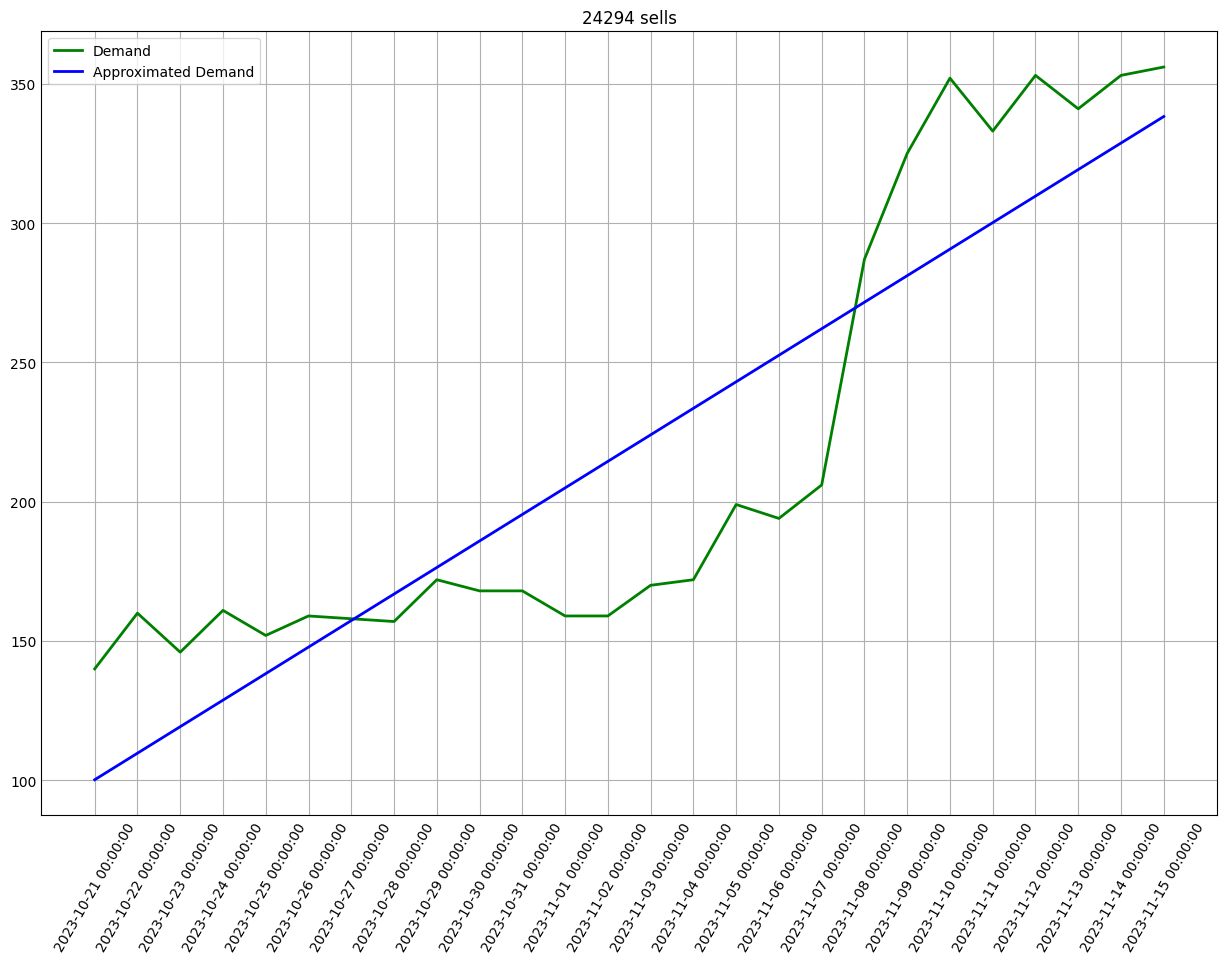

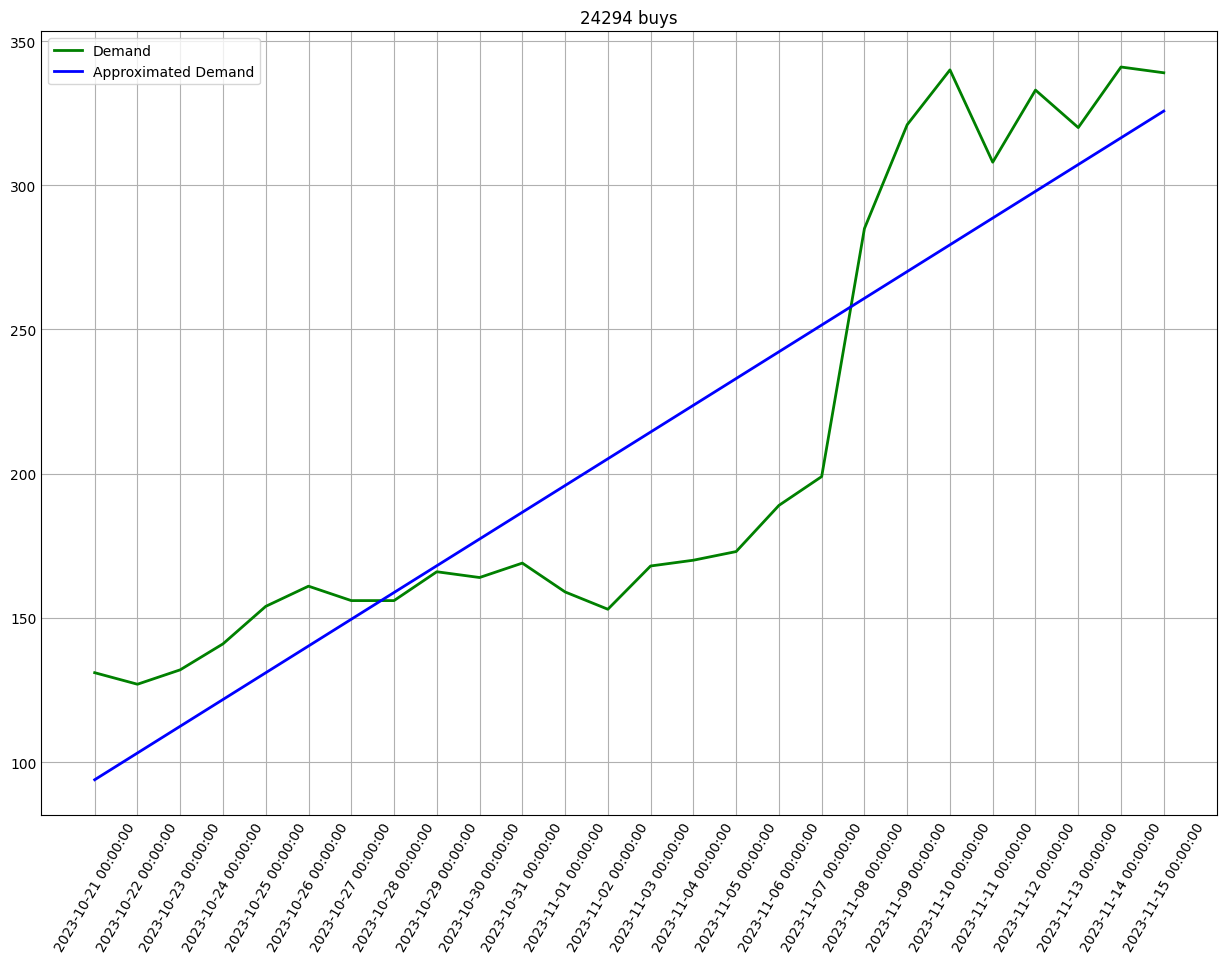

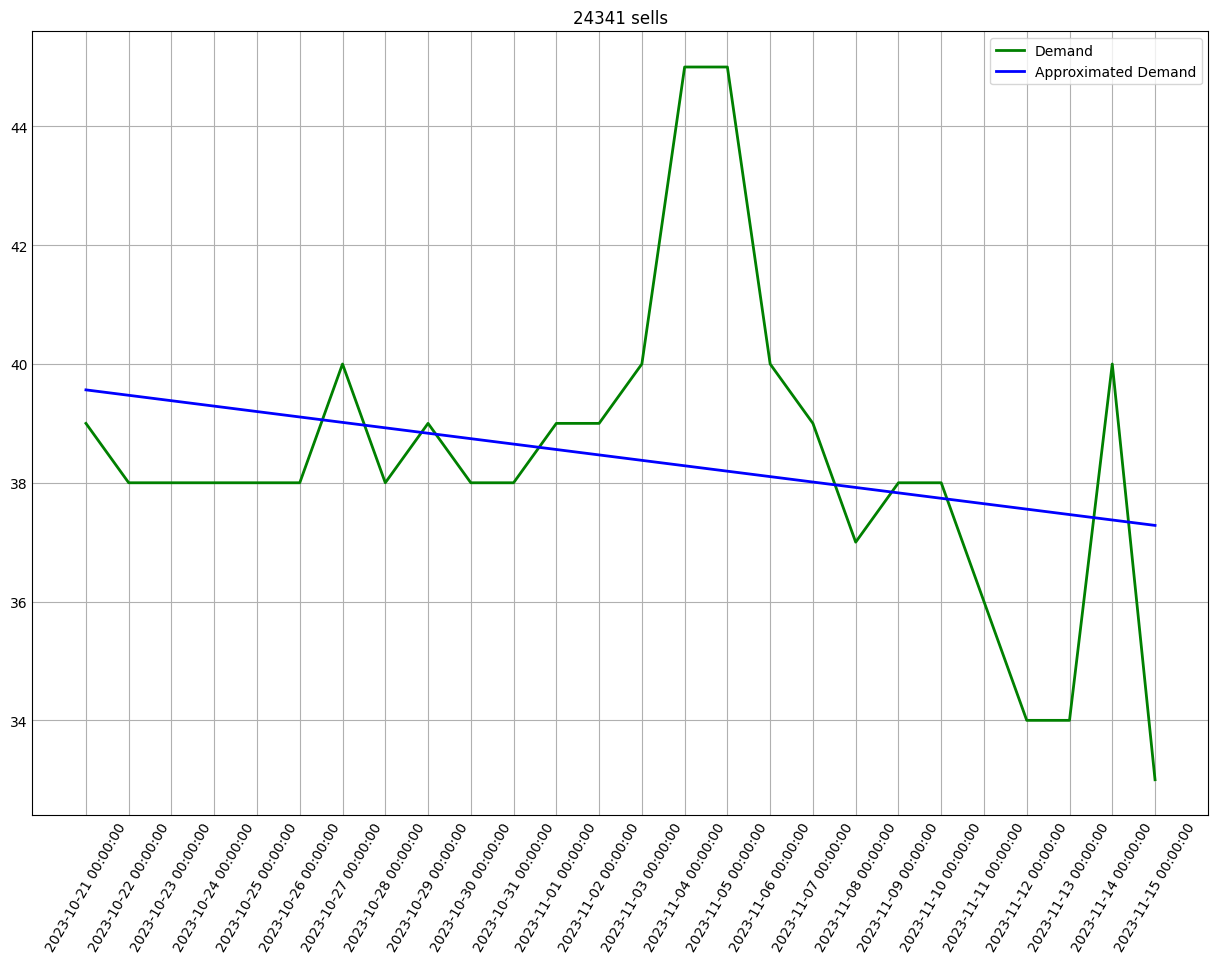

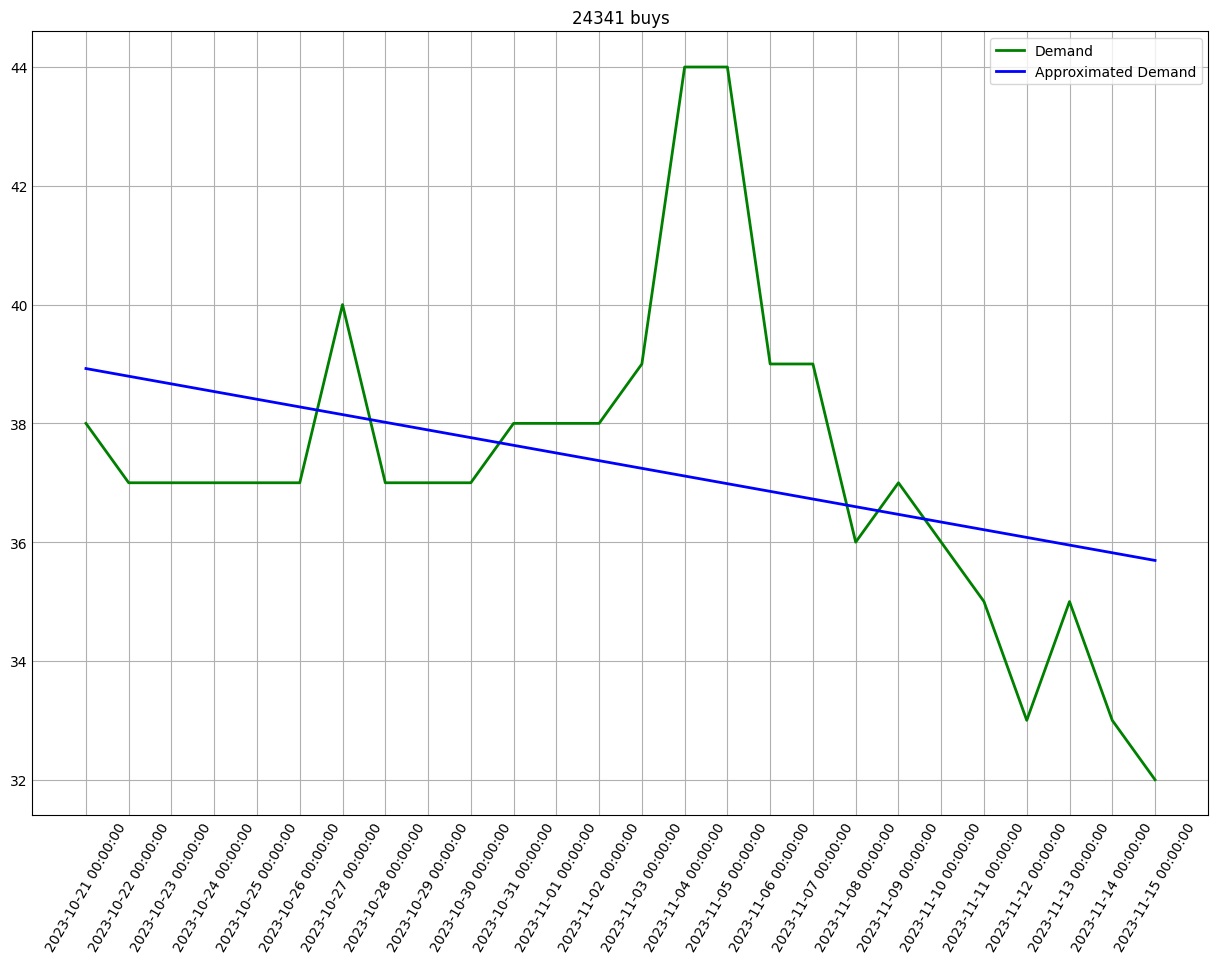

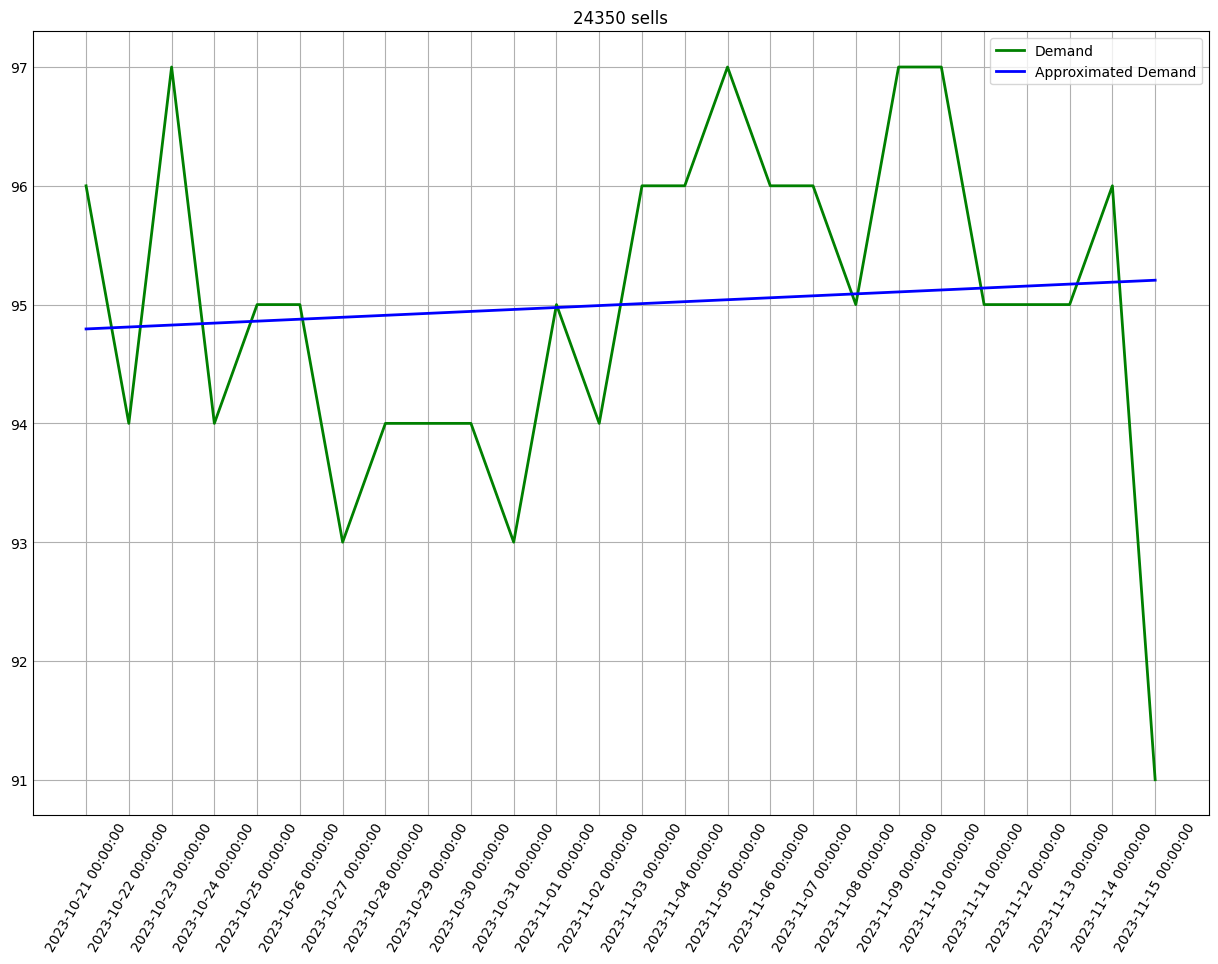

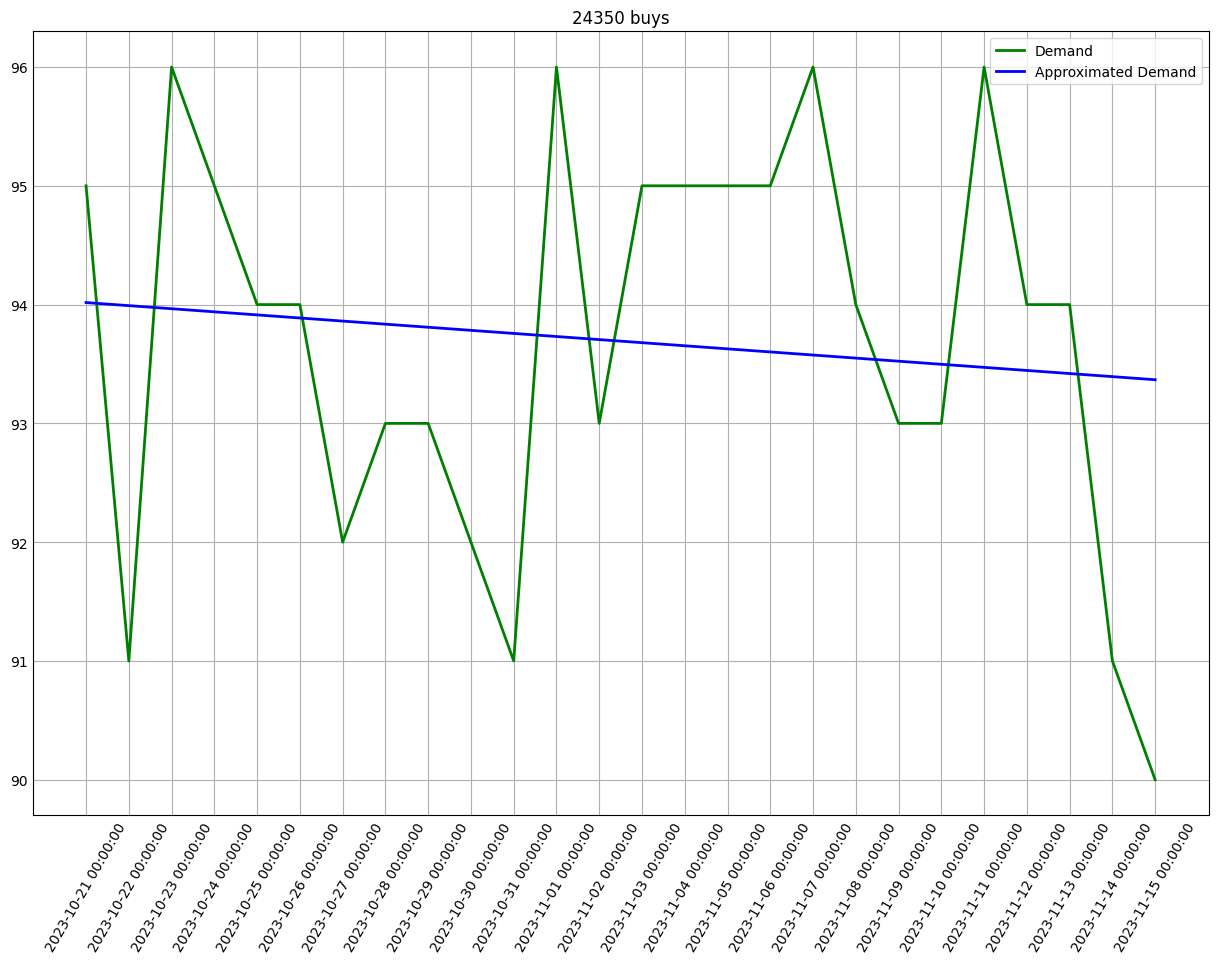

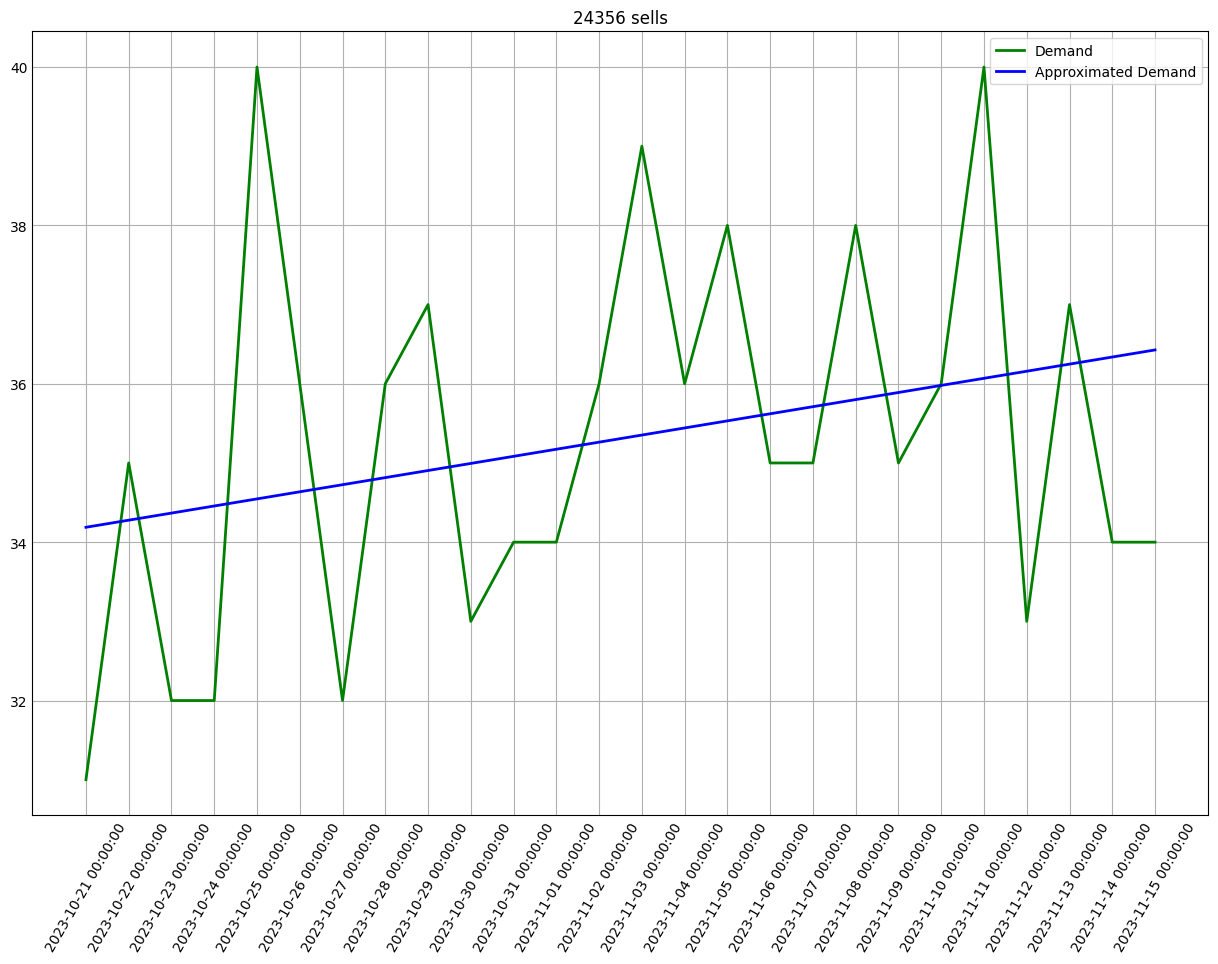

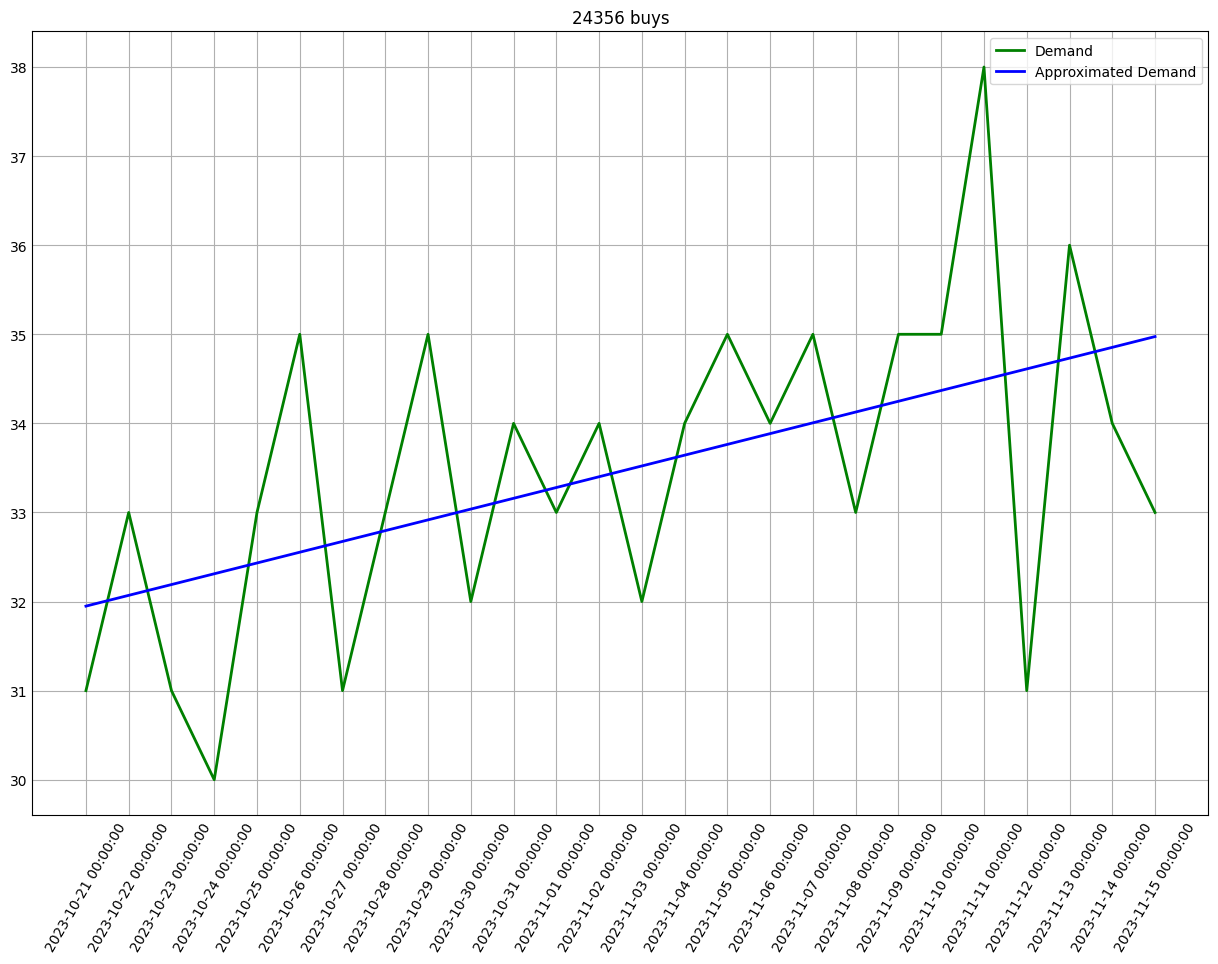

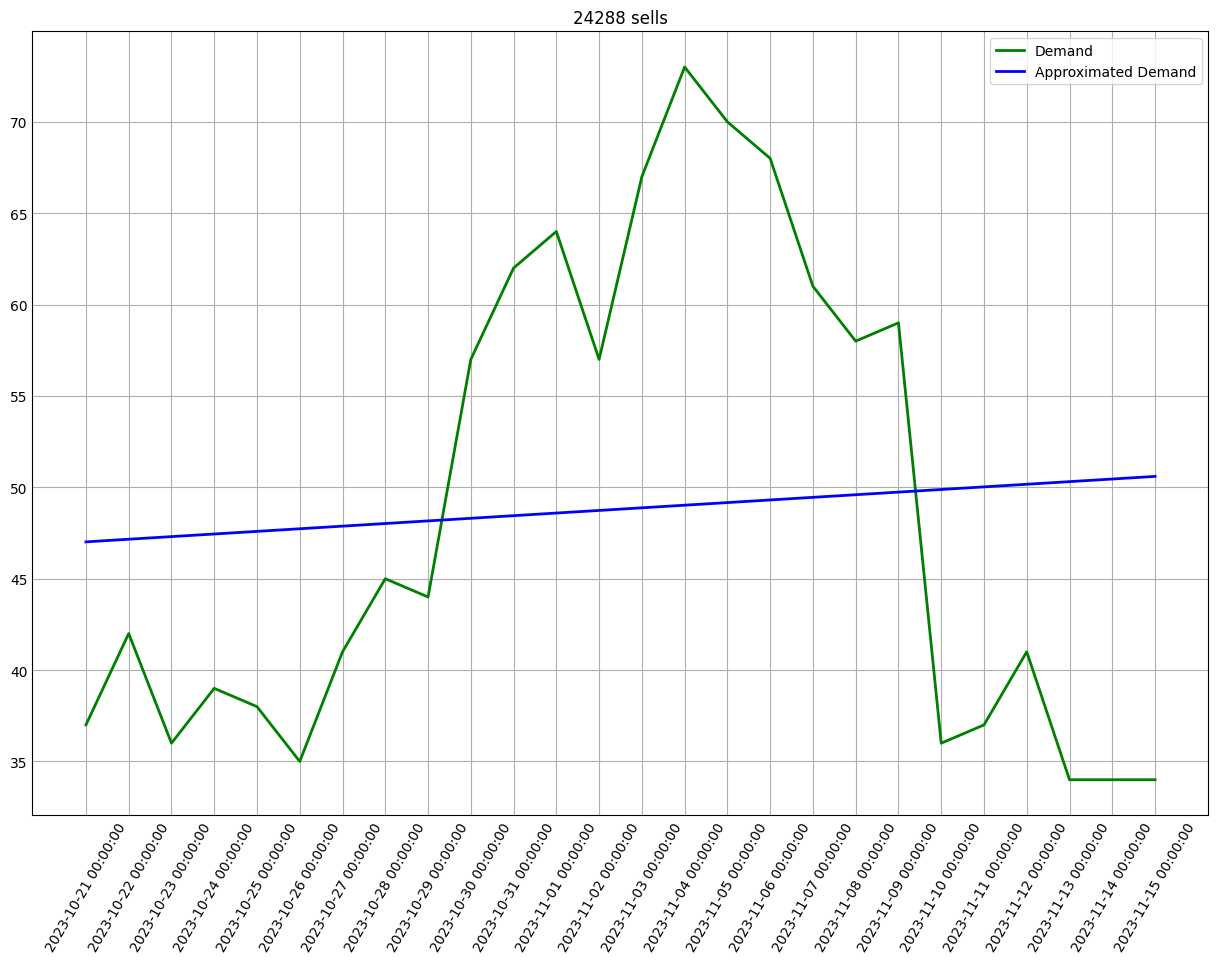

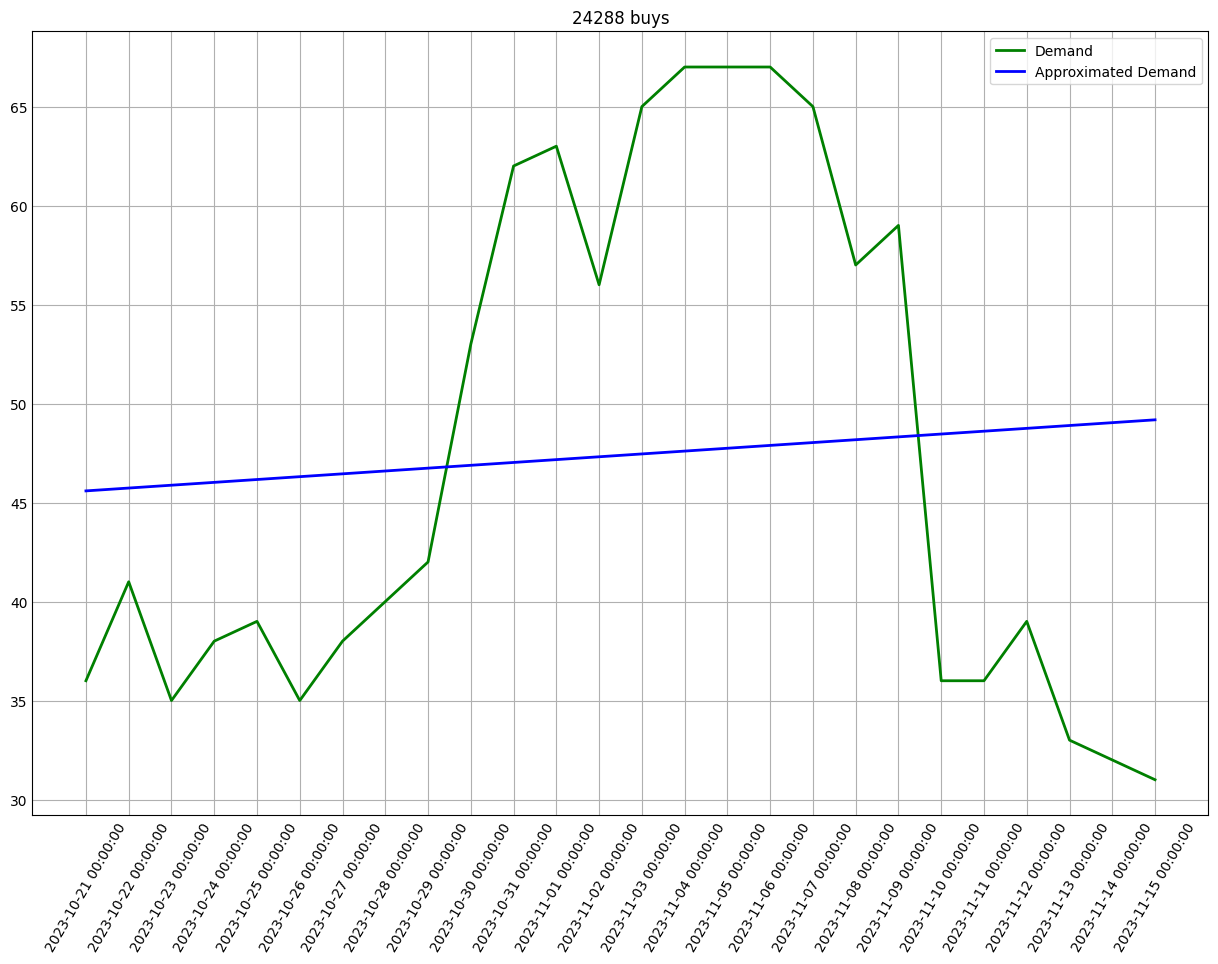

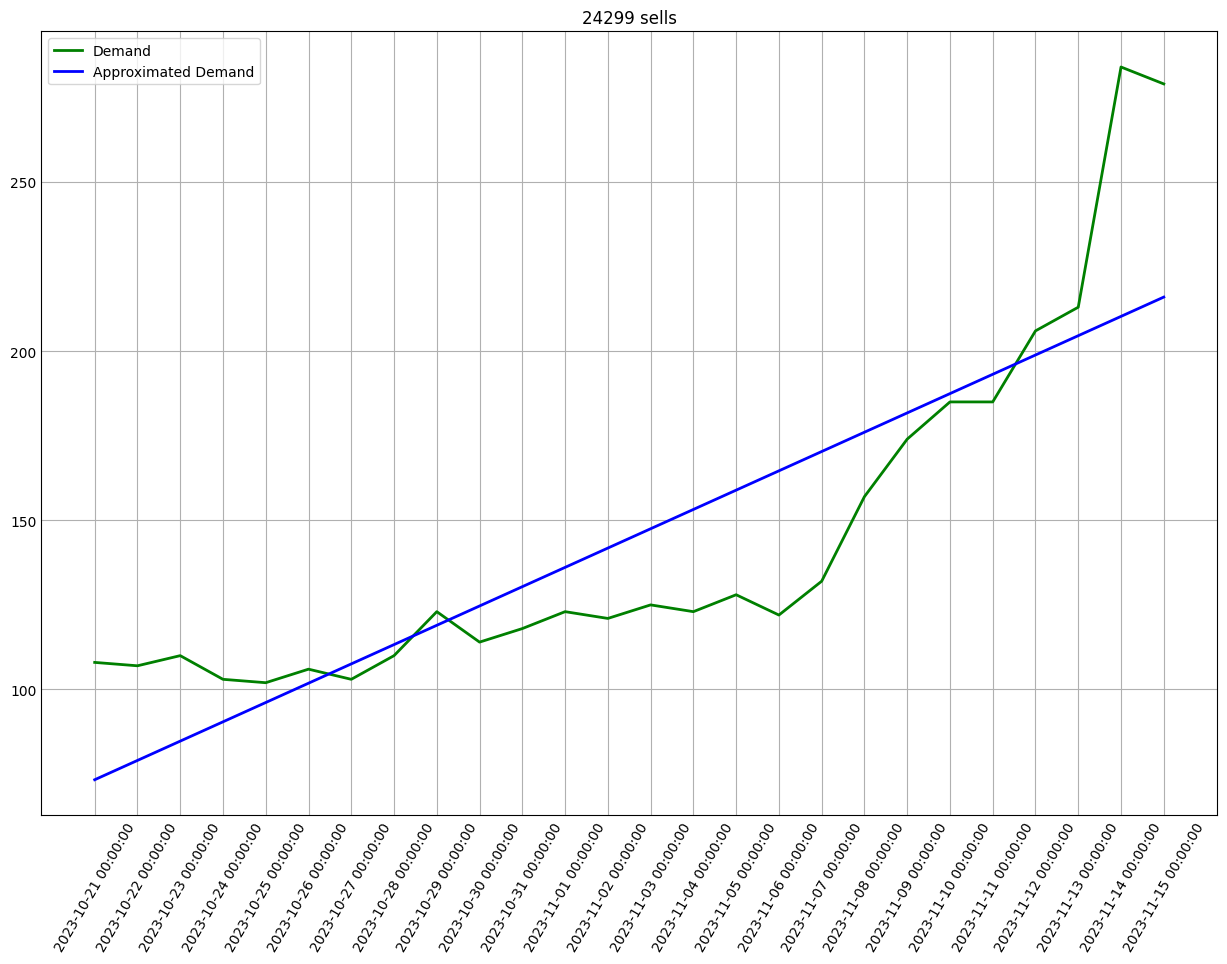

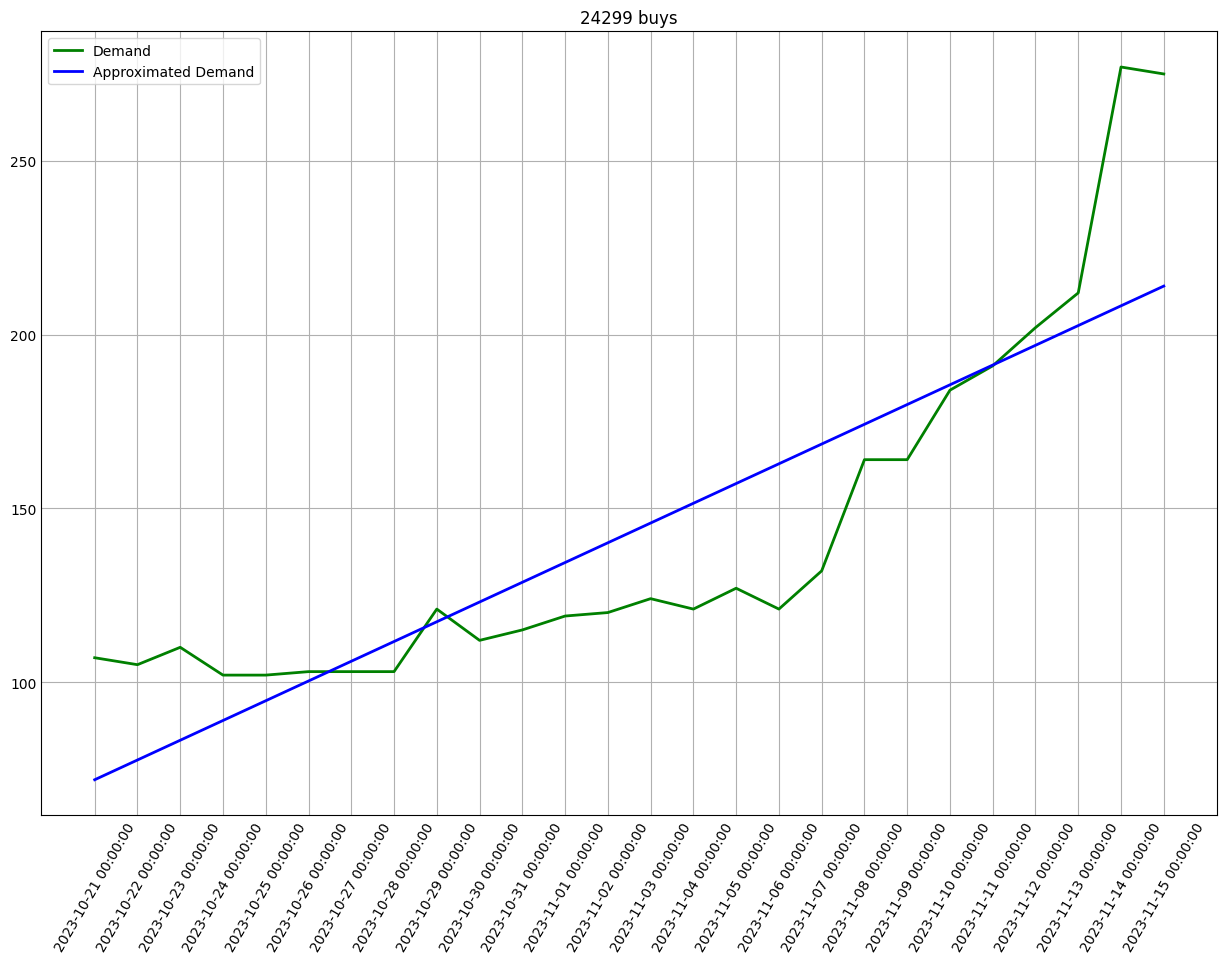

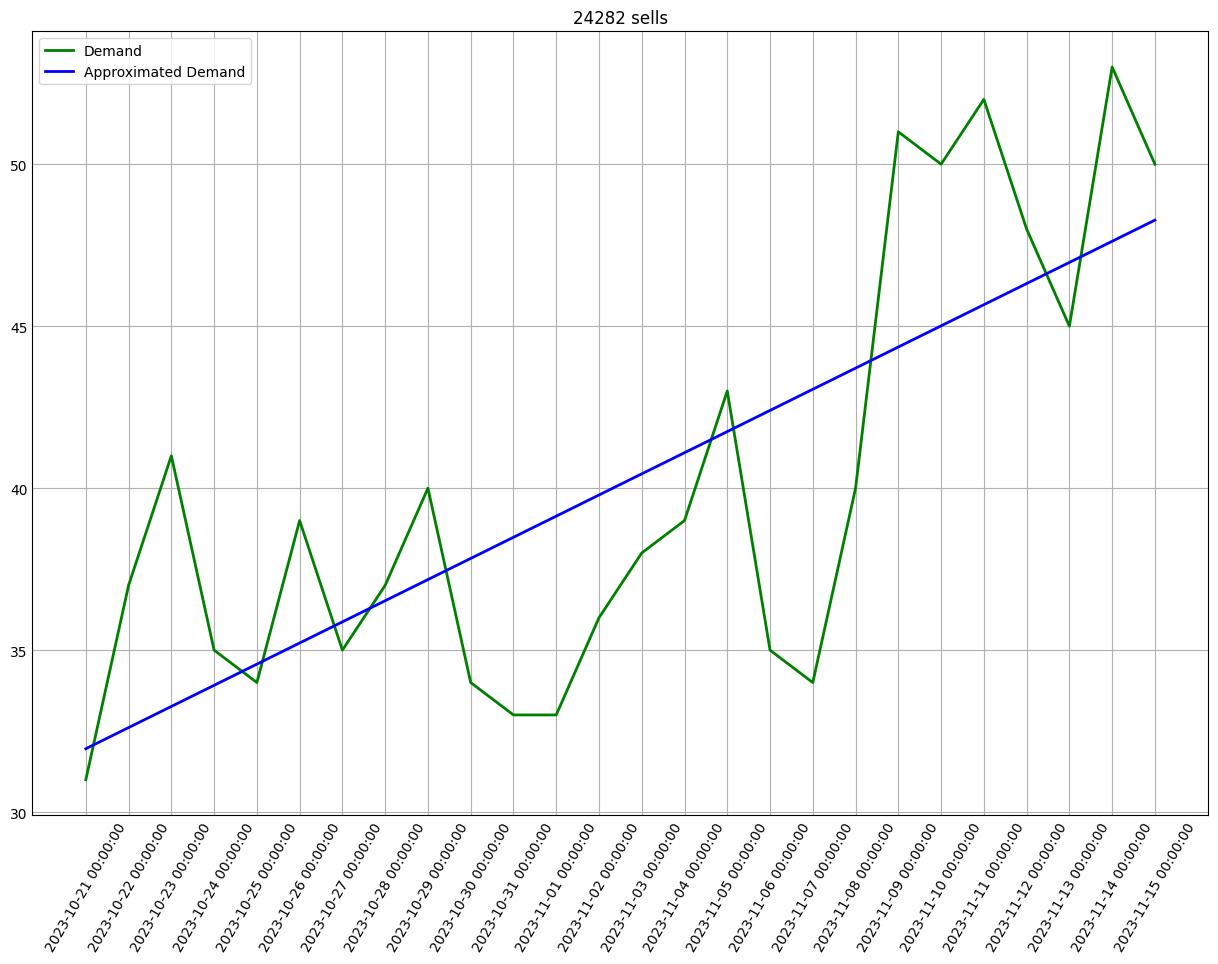

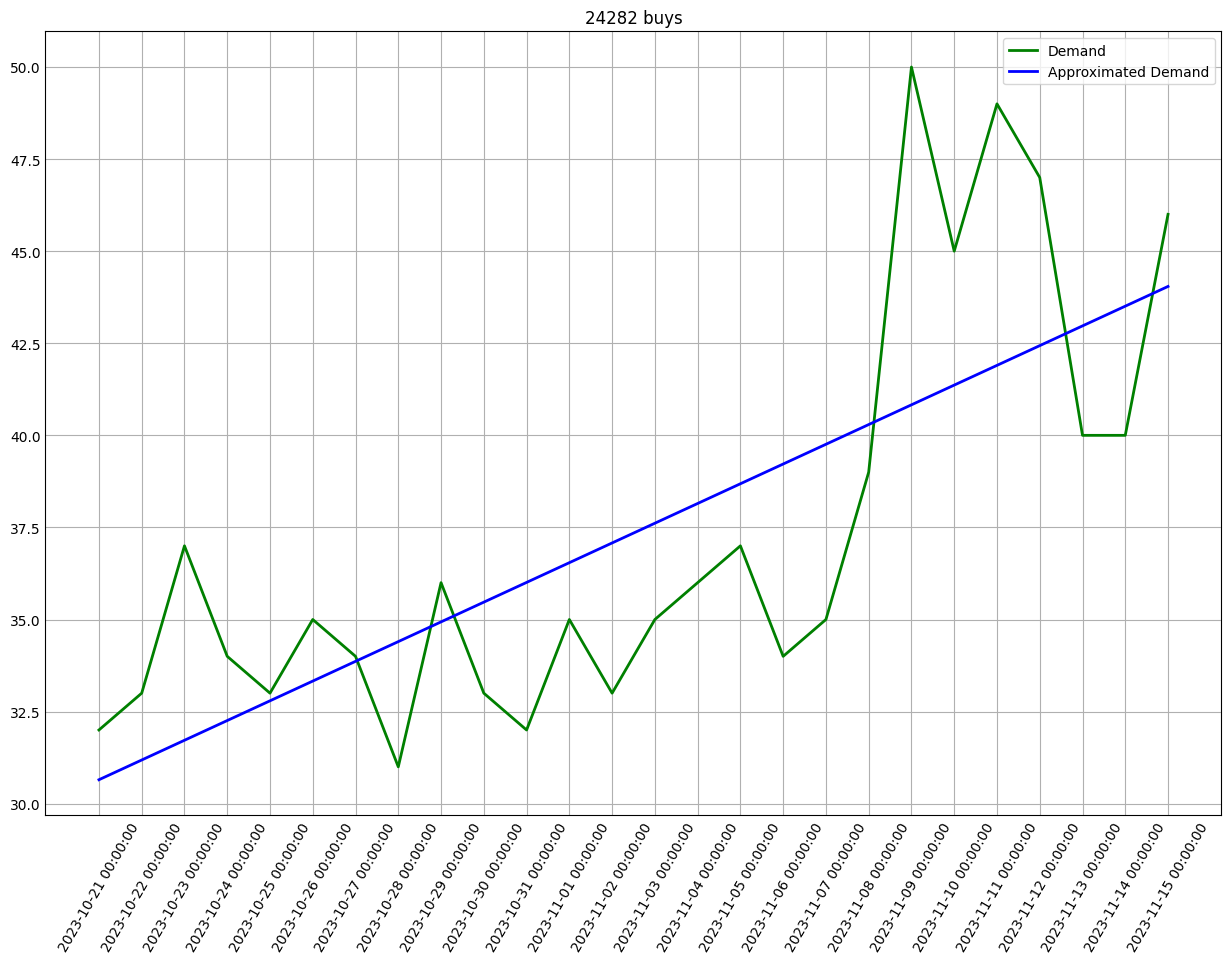

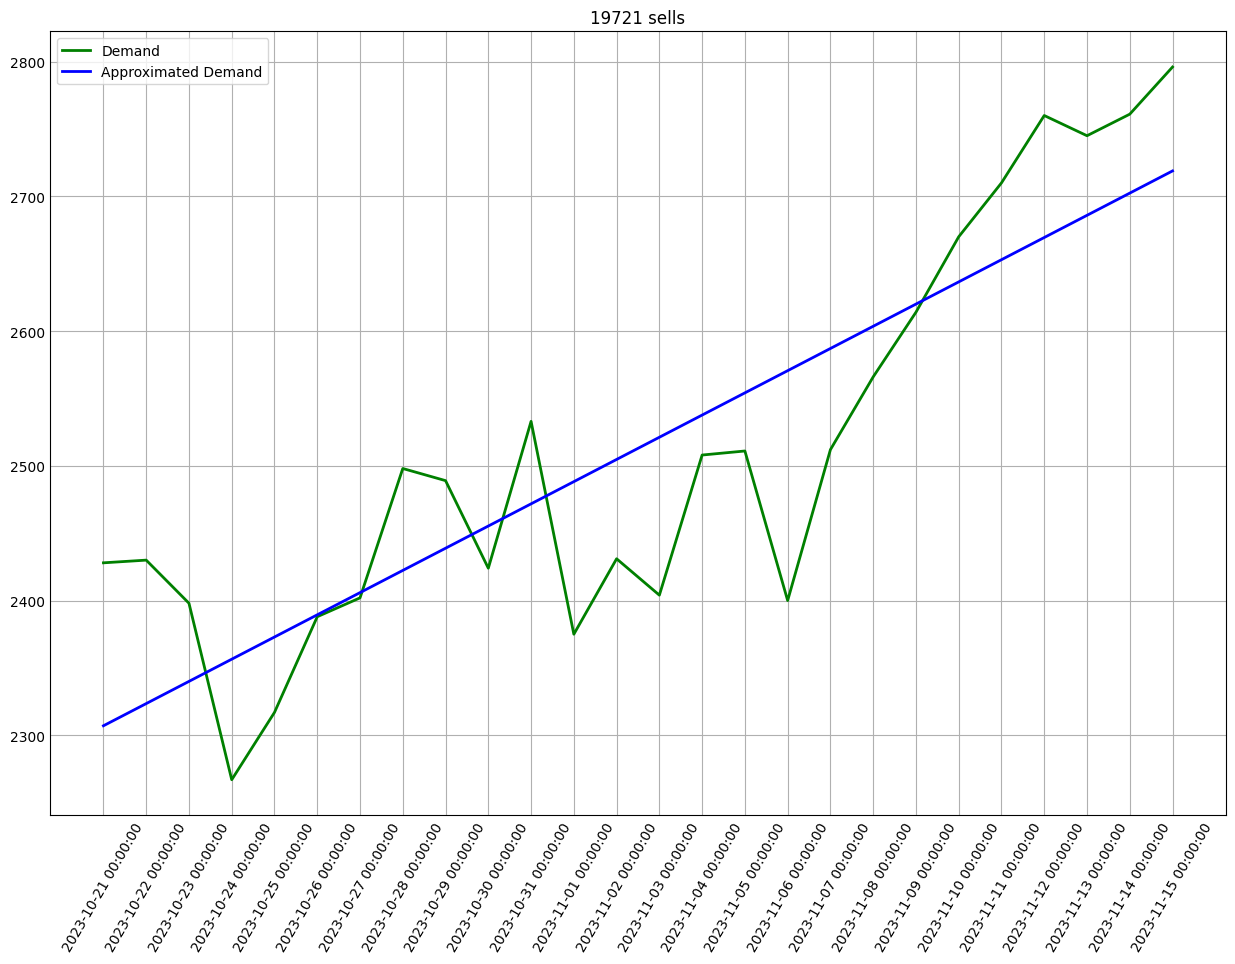

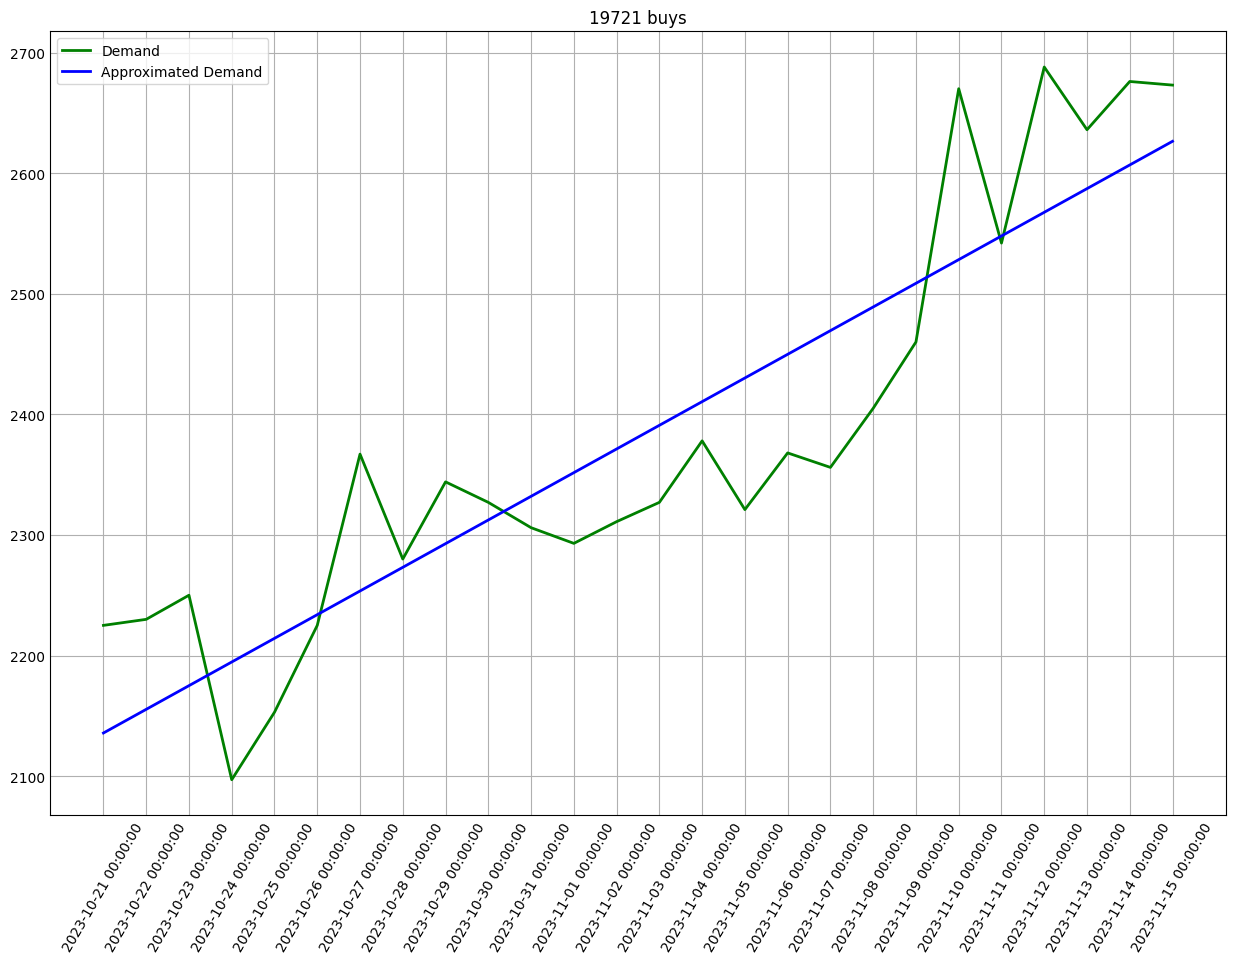

In [63]:
sells_items_dfs = []
buys_items_dfs = []
for i in subset_items:
    x = [str(datetime.datetime(d.year, d.month, d.day, 0, 0, 0, 0)) for d in sells_df['date']]
    y = [p for p in sells_df[i]]
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    regression_x = [i for i in range(len(x))]
    m,c = np.polyfit(regression_x,y,1)
    regression_y = [m*x + c for x in regression_x]
    ax.plot(x, y, linewidth=2.0, color='g')
    ax.plot(x, regression_y, linewidth=2.0, color='b')
    ax.legend(['Demand', 'Approximated Demand'])
    plt.title(f'{i} sells')
    plt.xticks(rotation=60)
    plt.show()

    x = [str(datetime.datetime(d.year, d.month, d.day, 0, 0, 0, 0)) for d in buys_df['date']]
    y = [p for p in buys_df[i]]
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    regression_x = [i for i in range(len(x))]
    m,c = np.polyfit(regression_x,y,1)
    regression_y = [m*x + c for x in regression_x]
    ax.plot(x, y, linewidth=2.0, color='g')
    ax.plot(x, regression_y, linewidth=2.0, color='b')
    ax.legend(['Demand', 'Approximated Demand'])
    plt.title(f'{i} buys')
    plt.xticks(rotation=60)
    plt.show()

pib = PIB.objects().all()
x = [str(datetime.datetime(p.year, p.month, p.day, 0, 0, 0, 0)) for p in pib]
y = [p.value for p in pib]
# plot
    